In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import random
import os
import pickle
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path
from cycler import cycler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import entropy
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from scipy.spatial.distance import pdist
from tqdm.auto import tqdm

path = Path(os.getcwd()).parent

In [24]:
def plot_auc_median(auc_score, std_aucs, drop, file_name, save=False, mrs_iteration=None):
    aucs_upper = np.minimum(auc_score + std_aucs, 1)
    aucs_younger = np.maximum(auc_score - std_aucs, 0)
    x_labels = range(0, (len(auc_score)*drop), drop)
    plt.fill_between(x_labels, aucs_younger, aucs_upper, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score, color='blue', label='Median AUROC',  linestyle='-')
    plt.plot((len(x_labels)-1)*drop *[0.5], color='black', linestyle='--', label='Chance')
    if mrs_iteration is not None:
        minimum = min(0.5, np.min(aucs_younger))
        maximum = plt.gca().get_ylim()[1]
        plt.margins(0.05, 0)
        plt.vlines(mrs_iteration, minimum, maximum, colors='black', linestyles='solid')
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

    
def plot_auc(auc_score, drop, file_name,  save=False, mrs_iteration=None):
    x_labels = range(0, (len(auc_score)*drop), drop)
    plt.plot(x_labels, auc_score, color='blue', linestyle='-', label='AUROC')
    plt.plot((len(x_labels)-1)*drop *[0.5], color='black', linestyle='--', label='Chance')
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    if mrs_iteration is not None:
        minimum = min(0.5, np.min(auc_score - std_aucs))
        maximum = plt.gca().get_ylim()[1]
        plt.margins(0.05, 0)
        plt.vlines(mrs_iteration, minimum, maximum, colors='black', linestyles='solid')
        
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
   

def plot_rocs(rocs, file_name,  save=False):
    default_cycle = (cycler('linestyle',['-',':','-.', (0, (3, 5, 1, 5, 1, 5))]) +
                    cycler(color=['blue', 'orange', 'red', 'green']))
    plt.rc('')
    plt.rc('axes', prop_cycle=default_cycle)
    for fper, tper, std, deleted_elements in rocs:
        tpfrs_higher = np.minimum(tper + std, 1)
        tpfrs_lower = np.maximum(tper - std, 0)
        plt.plot(fper, tper, label=f'{int(deleted_elements[0])} samples removed')
        plt.fill_between(fper, tpfrs_lower, tpfrs_higher, alpha=0.2)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_mmds(mmds, drop, mmd_iteration, file_name,  save=False):
    plt.plot([*range(0, len(mmds)* drop * mmd_iteration, drop * mmd_iteration)], mmds)
    plt.ylabel('Maximum Mean Discrepancy')
    plt.xlabel('Number of removed observations')
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_mmds_median(mmds, std, drop, mmd_iteration, file_name,  save=False):
    mmds_upper = np.minimum(mmds + std, 1)
    mmds_younger = np.maximum(mmds - std, 0)
    x_labels = [*range(0, len(mmds)* drop * mmd_iteration, drop * mmd_iteration)]
    plt.fill_between(x_labels, mmds_younger, mmds_upper, color='black', alpha=0.2)
    plt.plot(x_labels, mmds)
    plt.ylabel('Maximum Mean Discrepancy')
    plt.xlabel('Number of removed observations')
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
   

def plot_class_ratio(ratios, representative_ratio, file_name,  save=False):
    plt.xlabel('Removed Examples')
    plt.ylabel('Ratio Age')
    plt.plot(ratios, label='non-representative', linestyle='-', color='blue')
    plt.plot(len(ratios)*[representative_ratio], color='black', linestyle='--', label='representative')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
  
    
def plot_experiment_comparison_auc(auc_score_mrs, std_aucs_mrs, auc_score_experiment, std_aucs_experiment, 
                               experiment_label, drop, file_name,  save=False):
    aucs_upper = np.minimum(auc_score_mrs + std_aucs_mrs, 1)
    aucs_lower = np.maximum(auc_score_mrs - std_aucs_mrs, 0)
    
    aucs_upper_experiment = np.minimum(auc_score_experiment + std_aucs_experiment, 1)
    aucs_lower_experiment = np.maximum(auc_score_experiment - std_aucs_experiment, 0)
    
    x_labels = range(0, (len(auc_score_mrs)*drop), drop)
    
    plt.fill_between(x_labels, aucs_lower, aucs_upper, color='orange', alpha=0.2)
    plt.plot(x_labels, auc_score_mrs, color='orange', linestyle='-', label='MRS')
    
    plt.fill_between(x_labels, aucs_lower_experiment, aucs_upper_experiment, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score_experiment, linestyle=':', color='blue', label=experiment_label)
    
    plt.plot(len(auc_score_mrs)*drop*[0.5], color='black', linestyle='--', label='Chance')
    
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_experiment_comparison_mmd(median_mmd, std_mmd,  median_mmd_experiment, std_mmd_experiment, 
                               experiment_label, drop, mmd_iteration, file_name,  save=False):
    mmd_upper = np.minimum(median_mmd + std_mmd, 1)
    mmd_lower = np.maximum(median_mmd - std_mmd, 0)
    
    mmd_upper_experiment = np.minimum(median_mmd_experiment + std_mmd_experiment, 1)
    mmd_lower_experiment = np.maximum(median_mmd_experiment - std_mmd_experiment, 0)
    
    x_labels = range(0, (len(median_mmd)*drop*mmd_iteration), mmd_iteration*drop)
    
    plt.fill_between(x_labels, mmd_lower, mmd_upper, color='orange', alpha=0.2)
    plt.plot(x_labels, median_mmd, color='orange', linestyle='-', label='MRS')
    
    plt.fill_between(x_labels, mmd_lower_experiment, mmd_upper_experiment, color='blue', alpha=0.2)
    plt.plot(x_labels, median_mmd_experiment, linestyle=':', color='blue', label=experiment_label)
    
    plt.ylabel('Maximum mean discrepancy')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

In [3]:
def stacked_histograms(representative_probabilities, nonrepresentative_propabilities, chosen_samples,
                       directory, iteration, save_figure=False, temperature=0):
    n_bins = 50
    labels = ['Representative', 'Nonrepresentative']
    vax = plt.axes()
    plt.xlabel('Probability of being non-representative')
    plt.ylabel('Number of elements')
    colors = ['blue', 'red']
    weights = ((np.ones(len(representative_probabilities)) / len(representative_probabilities)),
               (np.ones(len(nonrepresentative_propabilities)) / len(nonrepresentative_propabilities)))
    counts, bins, bars = plt.hist((representative_probabilities, nonrepresentative_propabilities), n_bins,
             histtype='bar', stacked=True, label=labels, color=colors, weights=weights)
    maximum = plt.gca().get_ylim()[1]
    plt.margins(0.05, 0)
    plt.vlines(chosen_samples, 0, maximum, colors='black', linestyles='dashed')
    plt.legend()
    if save_figure:
        os.makedirs(f'{directory}/histograms/', exist_ok=True)
        plt.savefig(f'{directory}/histograms/histogram_temperature_{temperature}_iteration_{iteration}.pdf')
    plt.show()

In [4]:
from sklearn.metrics.pairwise import rbf_kernel  

def calculate_rbf_gamma(aggregate_set):
    all_distances = pdist(aggregate_set.values, 'euclid')
    sigma = sum(all_distances)/len(all_distances)
    return 1 / (2 * (sigma ** 2))

def maximum_mean_discrepancy(x, y):
    gamma = calculate_rbf_gamma(pd.concat([x, y]))
    x_x_rbf_matrix = rbf_kernel(x, x, gamma)
    y_y_rbf_matrix = rbf_kernel(y, y, gamma)
    x_y_rbf_matrix = rbf_kernel(x, y, gamma)
    
    maximum_mean_discreprancy = x_x_rbf_matrix.mean() + y_y_rbf_matrix.mean() - 2 * x_y_rbf_matrix.mean()
    return maximum_mean_discreprancy

# MRS Algorithm

To alyoung statistical inference in social sciences, survey participants must be selected at random
from the target population. When samples are drawn from parts of the population that are
close to hand, subgroups might be over-represented. This leads to statistical analyses under
sampling bias, which in turn may produce similarly biased outcomes. This notebook uses machine learning to reduce this selection bias in a psychological survey (**GBS**) using auxiliary information (**GESIS**/**Allensbach**) from comparable studies that are known to be representative. The proposed algorithm is first tested on US national Census data.

In [5]:
def grid_search(X_train, y_train, cv=5):
    clf = DecisionTreeClassifier()
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    ccp_alphas[ccp_alphas < 0] = 0
    param_grid = {'ccp_alpha': ccp_alphas}
    grid = GridSearchCV(DecisionTreeClassifier(random_state=5), param_grid, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

In [6]:
def temperature_sample(softmax: list,
                       temperature: float,
                       drop: int):
    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax)).astype('float64')
    softmax[softmax == 0] = EPSILON
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    count = 0
    while np.isnan(preds).any() and count < 100:
        preds = [0 if x != x else x for x in preds]
        preds = exp_preds / np.sum(exp_preds)
        count += 1
        
    if count == 100:
        return []
        
    if len(preds[preds != 0]) < drop:
        drop = len(preds[preds != 0]) 
    probas = np.random.choice(len(preds), drop, replace=False, p=preds)
    return probas

In [7]:
def MRS(N: pd.DataFrame, 
        columns,
        R: pd.DataFrame,
        number_of_splits = 5,
        temperature: float=0.5,
        n_drop: int=1,
        cv=5):
    """
    MRS Algorithm
    
    Input:
        * N: dataset that is assumed to not be representative.
        * R: dataset that is known to be representative.
        * temperature: temperature value for probabilistic sampling procedure.
        * drop: number of instances to drop per iteration (small values result in long runtimes).
        * number_of_splits: splits per iteration.
    
    Output:
        * N/Drop: N without the dropped elements
    """
    preds = []
    bootstrap_iterations = 5
    
    kf = KFold(n_splits=number_of_splits)
    for train_index, test_index in kf.split(N):
        N_train, N_test = N.iloc[train_index], N.iloc[test_index]
        n = min(len(R), len(N_train))
        bootstrap_predictions = []
        for j in range(bootstrap_iterations):
            bootstrap = pd.concat([N_train.sample(n=n, replace=True),
                                      R.sample(n=n, replace=True)], sort=True)
            clf = grid_search(bootstrap[columns], bootstrap.label, cv)
            bootstrap_predictions.append(clf.predict_proba(N_test[columns])[:,1])
        preds.extend(np.mean(bootstrap_predictions, axis=0))
        
    drop_ids = temperature_sample(preds, temperature, n_drop)
    return N.drop(N.index[drop_ids])

In [8]:
def cv_bootstrap_prediction(N, R, number_of_splits, columns, cv):
    preds = np.zeros(len(N))
    preds_r = np.zeros(len(R))
    bootstrap_iterations = 5
    
    kf = KFold(n_splits=number_of_splits, shuffle=True)
    for split_n, split_r in zip(kf.split(N), kf.split(R)):
        train_index, test_index = split_n
        train_index_r, test_index_r  = split_r
        N_train, N_test = N.iloc[train_index], N.iloc[test_index]
        R_train, R_test = R.iloc[train_index_r], R.iloc[test_index_r]
        n = min(len(R_train), len(N_train))
        r = n
        bootstrap_predictions = []
        bootstrap_predictions_r = []
        for j in range(bootstrap_iterations):
            bootstrap = pd.concat([N_train.sample(n=n, replace=True),
                                      R_train.sample(n=r, replace=True)])
            clf = grid_search(bootstrap[columns], bootstrap.label, cv)
            bootstrap_predictions.append(clf.predict_proba(N_test[columns])[:,1])
            bootstrap_predictions_r.append(clf.predict_proba(R_test[columns])[:,1])
        preds[test_index]  = np.mean(bootstrap_predictions, axis=0)
        preds_r[test_index_r] = np.mean(bootstrap_predictions_r, axis=0)
    return preds, preds_r

In [9]:
def auc_prediction(N, R, columns, test_size, drop, iteration, cv=5, calculate_roc=False):
    data = pd.concat([N, R])
    auroc_scores = []
    rocs = []
    median_roc = None
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    for train, test in kf.split(data[columns], data['label']):
        train, test = data.iloc[train], data.iloc[test]
        y_train = train['label']
        clf = grid_search(train[columns], y_train, cv)
        y_predict = clf.predict_proba(test[columns])[:,1]
        y_test = test['label']
        auroc_scores.append(roc_auc_score(y_test, y_predict))
        if calculate_roc:
            rocs.append(interpolate_roc(y_test, y_predict, drop, iteration))
    if calculate_roc:
        median_roc = calculate_median_roc(rocs)
        
    return np.mean(auroc_scores), median_roc

In [10]:
def interpolate_roc(y_test, y_predict, drop, iteration):
    interpolation_points = 250
    median_fpr = np.linspace(0, 1, interpolation_points)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    interp_tpr = np.interp(median_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return (median_fpr, interp_tpr, [iteration * drop] * interpolation_points)

def calculate_median_roc(rocs):
    rocs = np.array(rocs)
    median_fpr = np.median(rocs[:, 0], axis = 0)
    median_tpr = np.median(rocs[:, 1], axis = 0)
    std_tpr = np.std(rocs[:, 1], axis = 0)
    removed_samples = rocs[0, 2]
    return (median_fpr, median_tpr, std_tpr, removed_samples)

def calculate_median_rocs(rocs):
    rocs = np.array(rocs)
    median_rocs = []
    for i in range(rocs.shape[1]):
        rocs_at_iteration = rocs[:, i]
        median_fpr = np.median(rocs_at_iteration[:, 0], axis = 0)
        median_tpr = np.median(rocs_at_iteration[:, 1], axis = 0)
        std_tpr = np.std(rocs_at_iteration[:, 1], axis = 0)
        removed_samples = rocs_at_iteration[0, 3]
        median_rocs.append((median_fpr, median_tpr, std_tpr, removed_samples))
    return median_rocs

In [11]:
def MRS_with_histogram(N, R, columns, number_of_splits = 5, temperature: float=0.5,
        n_drop: int=1, cv=5, directory='', iteration=0, temperature_sampling=True):
    """
    MRS Algorithm
    
    Input:
        * N: dataset that is assumed to not be representative.
        * R: dataset that is known to be representative.
        * temperature: temperature value for probabilistic sampling procedure.
        * drop: number of instances to drop per iteration (small values result in long runtimes).
        * number_of_splits: splits per iteration.
    
    Output:
        * N/Drop: N without the dropped elements
    """ 
    
    preds, preds_r = cv_bootstrap_prediction(N, R, number_of_splits, columns, cv)
    all_preds = np.concatenate([preds, preds_r])
    all_true = np.concatenate([np.ones(len(preds)), np.zeros(len(preds_r))])
    auc = roc_auc_score(all_true, all_preds)
    
    if temperature_sampling:
        mapped_auc = abs(auc - 0.5)
        temperature = 0.35 * - np.log2(mapped_auc) - 0.35
        print("auc", auc)
    else:
        temperature = 1
    drop_ids = temperature_sample(preds, temperature, n_drop)
    
    if iteration % 5 == 0:
        stacked_histograms(preds_r, preds, np.array(preds)[drop_ids], directory, iteration, True, temperature)
    
    return N.drop(N.index[drop_ids])

In [74]:
def repeated_MRS(df, columns, number_of_splits, n_drop=1,test_size=0.33, cv=5, us=False, directory='', 
                 compas_bias='', temperature_sampling=True, number_of_iterations=None, mmd_iteration = 5):
    
    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    if number_of_iterations is None:
        number_of_iterations = int(len(N) / drop)
    aucs = []
    rocs = []
    ratio = []
    mmds = []
    kl_values = []
    
    
    auroc_iteration = int(int(len(N) / n_drop) / 4) + 1
    
    if us:
        representative_ratio = (len(R[R[compas_bias] == 1]) /
                                len(R[R[compas_bias] == 0]))
        ratio.extend([len(N[N[compas_bias] == 1]) / 
                         (len(N[N[compas_bias] == 0]))]*drop)
        
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    rocs.append(roc)
    plot_rocs(rocs, '', save=False)
    mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.005
    mrs = N
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS_with_histogram(N, R, columns,
                                number_of_splits=number_of_splits,
                                n_drop=n_drop, cv=cv, directory=directory, iteration=i,
                                temperature_sampling=temperature_sampling)
        
        
        
        if((i+1) % auroc_iteration == 0):
            auc, roc = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=True)
            aucs.append(auc)
            rocs.append(roc)
            plot_rocs(rocs, '', save=False)
        else:
            auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
            aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = i + 1
            mrs = N.copy(deep=True)
            
        print(f'graph auc: {auc}')
        
        # only for US Census experiment
        if us:
            ratio.extend([len(N[N[compas_bias] == 1]) / 
                         (len(N[N[compas_bias] == 0]))]*drop)
            if ((i+1) % 10 == 0):
                plot_class_ratio(ratio, representative_ratio, directory + '/tmp_ratio', save=False)
                 
        if ((i+1) % mmd_iteration == 0):
            mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
            plot_mmds(mmds, drop, mmd_iteration, '', False)
            
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    
    if us:
        return ratio, aucs, rocs, mrs, mmds, mrs_iteration * n_drop
    else:
        return aucs, rocs, mrs, mmds, mrs_iteration * n_drop

## Experiment 1
### <font color='darkblue'>US National Census (Income)</font>  <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=27Y".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [13]:
columns = ['age', 'c_charge_degree', 'race', 'score_text', 'sex', 'priors_count', 
         'is_violent_recid', 'decile_score', 'is_recid']

df = pd.read_csv(os.path.join(path, 'data/compas/compas-scores.csv'))
df = df[columns]
df['sex'].replace('Male', 0, inplace=True)
df['sex'].replace('Female', 1, inplace=True)

df = df.replace('-1', np.NaN)
df = df.replace(-1, np.NaN)
df.dropna(inplace=True)

compas_bias = 'age'

ctg = [
    'score_text',
    'c_charge_degree',
    'race'
      ]

for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)
    
compas_columns = list(df.columns)
meta = ['label', 'index', compas_bias]
for m in meta:
    if m in compas_columns:
        compas_columns.remove(m)
        
        
compas_scaling_columns = [
    'priors_count',
    'decile_score'
]


scale = StandardScaler()
df[compas_scaling_columns] = scale.fit_transform(df[compas_scaling_columns])
df.reset_index(drop=True, inplace=True)

In [14]:
df['age'].value_counts().sort_index()

18      6
19     65
20    302
21    467
22    466
     ... 
79      1
80      1
83      2
86      1
96      1
Name: age, Length: 66, dtype: int64

In [15]:
df = df.sample(frac=1)

age = 26
compas_bias = 'age'
df_copy = df.copy()
df_copy.loc[(df_copy.age <= age),'age'] = 1
df_copy.loc[(df_copy.age > age),'age'] = 0

df_old = df_copy[(df_copy[compas_bias] == 1)].copy()
df_young = df_copy[(df_copy[compas_bias] == 0)].copy()

rep_fraction = 0.2
bias_fraction = 0.3
young_normal = len(df_young)
old_normal = len(df_old)


#-----------------Simulate non-representative data---------------------#
rep = pd.concat([df_young.head(int(young_normal * 0.25)),
                df_old.head(int(old_normal * 0.25))],
                ignore_index=True) 

nonrep_more_young = pd.concat([df_young.tail(int(young_normal * (rep_fraction + bias_fraction))), 
                             df_old.tail(int(old_normal * (rep_fraction - 0.15)))],
                            ignore_index=True)

nonrep_more_old = pd.concat([df_young.tail(int(young_normal * (rep_fraction))),
                             df_old.tail(int(old_normal * (bias_fraction + rep_fraction)))], 
                             ignore_index=True)


#-----------------Simulate representative data---------------------#
rep2 = pd.concat([df_young.tail(int(young_normal * rep_fraction)),
                 df_old.tail(int(old_normal * rep_fraction))], 
                 ignore_index=True) 

rep['label'] = 0
nonrep_more_young['label'] = 1
nonrep_more_old['label'] = 1
rep2['label'] = 1

print("Current setting:")
print('Rep: \n', rep[compas_bias].value_counts())
print('Rep 2: \n', rep2[compas_bias].value_counts())
print('Nonrep_more_older: \n', nonrep_more_old[compas_bias].value_counts())
print('nonrep_more_younger: \n', nonrep_more_young[compas_bias].value_counts())

compas_nonrep_more_young = pd.concat([rep.copy(deep=True), nonrep_more_young.copy(deep=True)])
compas_nonrep_more_old = pd.concat([rep.copy(deep=True), nonrep_more_old.copy(deep=True)])
compas_rep = pd.concat([rep.copy(deep=True), rep2.copy(deep=True)])

Current setting:
Rep: 
 0    1934
1     822
Name: age, dtype: int64
Rep 2: 
 0    1547
1     657
Name: age, dtype: int64
Nonrep_more_older: 
 1    1644
0    1547
Name: age, dtype: int64
nonrep_more_younger: 
 0    3869
1     164
Name: age, dtype: int64


In [18]:
compas_nonrep_more_old[compas_columns].head()

sex  priors_count  is_violent_recid  decile_score  is_recid  \
0    1     -0.688567                 0     -0.839255       0.0   
1    1     -0.688567                 0     -0.839255       0.0   
2    0      0.988340                 1     -0.491264       1.0   
3    0     -0.688567                 0     -0.839255       0.0   
4    0     -0.688567                 0      0.204717       1.0   

   score_text_High  score_text_Low  score_text_Medium  c_charge_degree_F  \
0                0               1                  0                  0   
1                0               1                  0                  0   
2                0               1                  0                  0   
3                0               1                  0                  0   
4                0               0                  1                  1   

   c_charge_degree_M  c_charge_degree_O  race_African-American  race_Asian  \
0                  1                  0                      1           0   
1                  1                  0                      0           0   
2                  1                  0                      1           0   
3                  1                  0                      1           0   
4                  0                  0                      1           0   

   race_Caucasian  race_Hispanic  race_Native American  race_Other  
0               0              0                     0           0  
1               1              0                     0           0  
2               0              0                     0           0  
3               0              0                     0           0  
4               0              0                     0           0

In [20]:
data = compas_rep
maximum_mean_discrepancy(data[data['label']== 1][compas_columns], data[data['label']== 0][compas_columns])

0.00027018025259328837

## Experiment 1 a)


### Simulate non-representative data. More younger than in R

| income      | Representative (R) | Non-Representative (N) |
|-------------|--------------------|------------------------|
| young (<=27Y) | 3715               | ????                   |
| old (>50K) | 1168               | ????                   |

In [247]:
drop = 50
number_of_splits = 3
test_size = 0.3
cv = 3
mmd_iteration = 5
number_of_iterations = int(len(compas_nonrep_more_young[compas_nonrep_more_young['label'] == 1]) 
                           / drop) - 1
representative_ratio = (len(compas_rep[compas_rep[compas_bias] == 1]) 
                        / len(compas_rep[compas_rep[compas_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/compas_nonrep_more_young',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)
save = True

ratio, auc_more_young, roc, mrs, mmds, mrs_iteration = repeated_MRS(compas_nonrep_more_young, compas_columns,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = cv, us = True, directory=result_dir, 
                                             compas_bias=compas_bias, 
                                             number_of_iterations=number_of_iterations, 
                                                                    mmd_iteration=mmd_iteration)
    
file_name = os.path.join(result_dir, 'ratio_more_young' + compas_bias)
plot_class_ratio(ratio, representative_ratio, file_name, save=save)   
plot_auc(auc_more_young, drop, f'{file_name}_auc', save=save, mrs_iteration=mrs_iteration, save=save)
plot_mmds(mmds, drop, mmd_iteration, f'{file_name}_mmd', save)

NameError: name 'compas_nonrep_more_young' is not defined

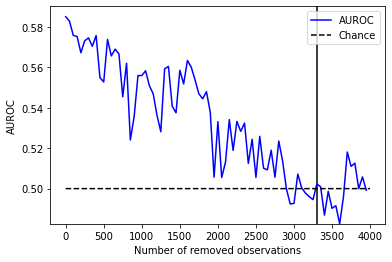

In [74]:
plot_auc(auc_more_young, drop, f'{file_name}_auc', save=save, mrs_iteration=3300)

In [ ]:
pickle.dump(ratio, open("results/ratio_more_young", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio_more_young", 'wb'))
pickle.dump(auc_more_young, open("results/auc_more_young", 'wb'))

### Load saved results

In [14]:
ratio = pickle.load(open("results/ratio_more_young", 'rb'))
representative_ratio = pickle.load(open("results/representative_ratio_more_young", 'rb'))
auc_more_young = pickle.load(open("results/auc_more_young", 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'results/ratio_more_low'

### Visualise results

In [ ]:
plot_class_ratio(ratio, representative_ratio, '', save=False)
plot_auc(auc_more_young, drop, '', save=False)

## Experiment 1 b)


### Simulate non-representative data. More older than in R

| income      | Representative (R) | Representative (N)     |
|-------------|--------------------|------------------------|
| young (<=27Y) | 3715               | ????                   |
| old (>50K) | 1168               | ???                    |


  0%|          | 0/62 [00:00<?, ?it/s]

auc 0.5169686468519271


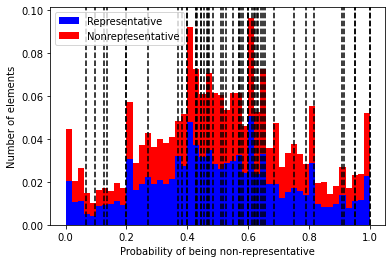

graph auc: 0.5496580465702345
auc 0.5297519371355669
graph auc: 0.539267713683119
auc 0.5200923933382136
graph auc: 0.5484151662473946
auc 0.5116915698325115
graph auc: 0.5506331410406144
auc 0.5161056464021965
graph auc: 0.5489451773046354
auc 0.513522473177128


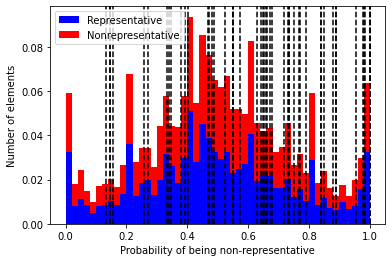

graph auc: 0.5561932199396974
auc 0.5072065651923114
graph auc: 0.5515211203960139
auc 0.49716761458408365
graph auc: 0.5546674341951066
auc 0.5055985468531184
graph auc: 0.547585665309511
auc 0.5024195162529539
graph auc: 0.5388635253396584


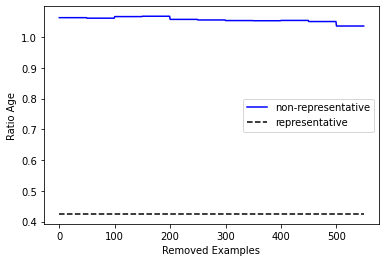

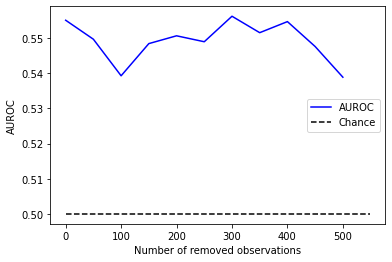

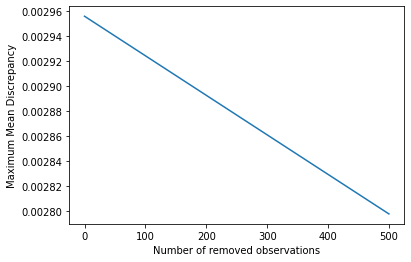

auc 0.497334958920748


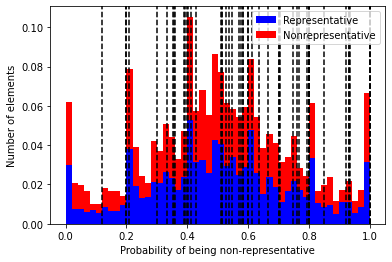

graph auc: 0.5521429793952966
auc 0.508173554350317
graph auc: 0.5539118638916426
auc 0.5042821556588368
graph auc: 0.5428634264376109
auc 0.5046889931109485
graph auc: 0.5276842041979096
auc 0.4833413350470985
graph auc: 0.5452829639971932
auc 0.49597295892794185


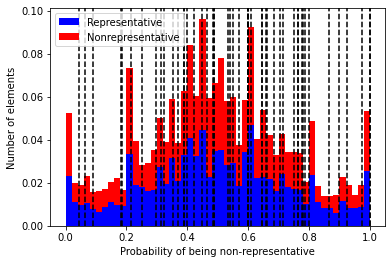

graph auc: 0.5632850923986709
auc 0.5005158131090283
graph auc: 0.5532749214799046
auc 0.5044841777390358
graph auc: 0.5452673726537753
auc 0.4940163091645925
graph auc: 0.5550965036173199
auc 0.5031350203264274
graph auc: 0.532390275580382


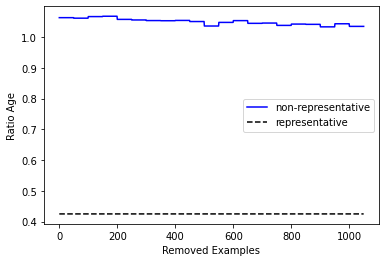

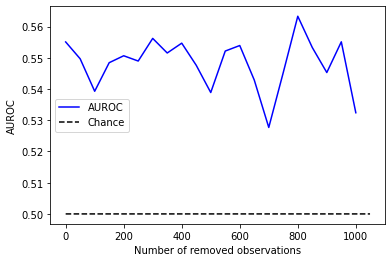

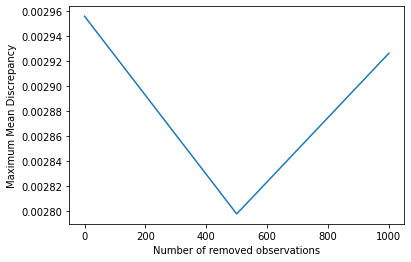

auc 0.4882631082823982


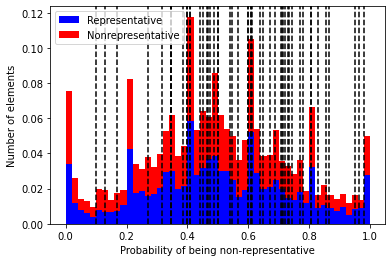

graph auc: 0.5299595141700405
auc 0.5072309644652846
graph auc: 0.5549835113349074
auc 0.4948826923597504
graph auc: 0.5409322092953122
auc 0.49683999775288723
graph auc: 0.5441256608990012
auc 0.49025586109918434
graph auc: 0.5450693532962557
auc 0.48194459710965504


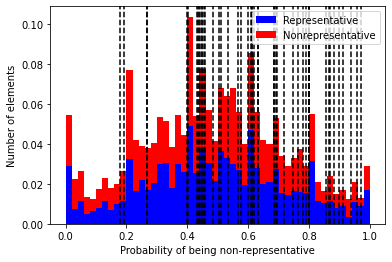

graph auc: 0.5381988039205501
auc 0.48240404666823755
graph auc: 0.5520144412710205
auc 0.4806834961437157
graph auc: 0.5462673693338619
auc 0.48236779365299326
graph auc: 0.5292763397473281
auc 0.4739197815178871
graph auc: 0.5325761178680096


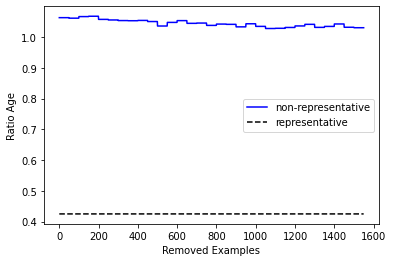

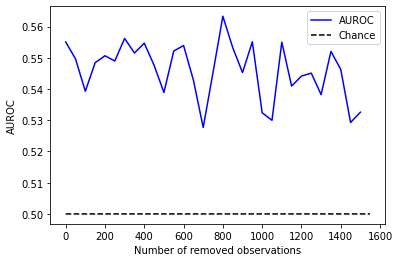

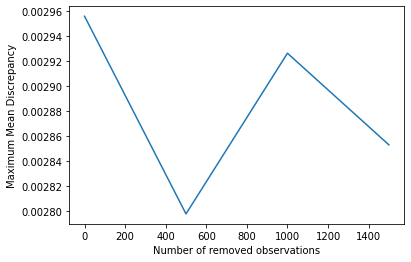

auc 0.4766782694002827


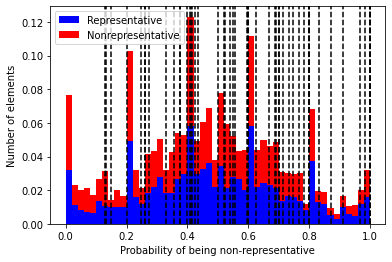

graph auc: 0.5214253978709343
auc 0.46950236103335335
graph auc: 0.5309991501495799
auc 0.4487143757657141
graph auc: 0.5278689122513315
auc 0.4509902999673181
graph auc: 0.5165172535597267
auc 0.46142566575067245
graph auc: 0.5253766482986577
auc 0.450746034895538


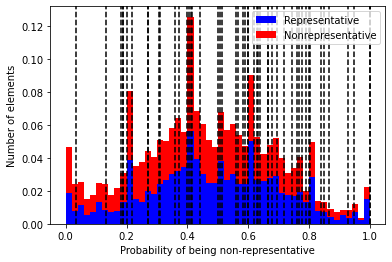

graph auc: 0.5122510527378109
auc 0.4411264254240666
graph auc: 0.5385673954943379
auc 0.44314973012579706
graph auc: 0.5313985500110002
auc 0.441347320233075
graph auc: 0.5197286755603522
auc 0.4404921530812854
graph auc: 0.5257511985042937


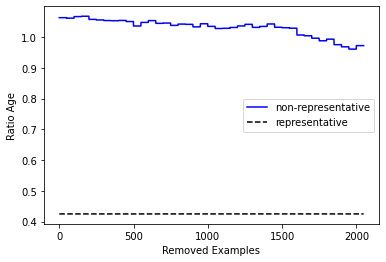

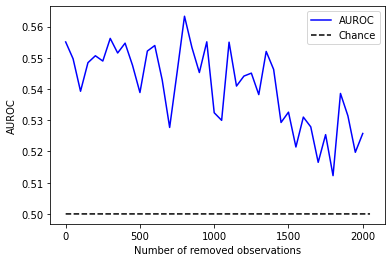

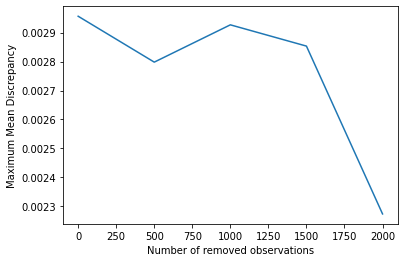

auc 0.4370298403970758


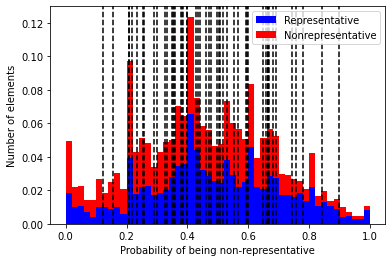

graph auc: 0.5167916318546626
auc 0.4380034828003343
graph auc: 0.514979823187432
auc 0.43524702041641666
graph auc: 0.5
auc 0.418068899364098
graph auc: 0.5134474529083146
auc 0.43024923879501875
graph auc: 0.5103151391829281
auc 0.4052090386504799


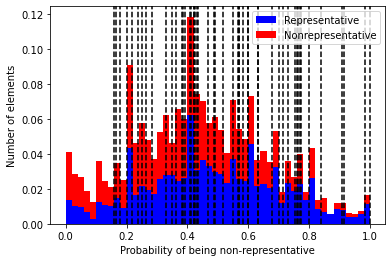

graph auc: 0.5
auc 0.40702297935002335
graph auc: 0.5108352778497969
auc 0.4078844730079783
graph auc: 0.5064217849436374
auc 0.40496542195490265
graph auc: 0.5079609555108647
auc 0.40443718428593534
graph auc: 0.49608511722934445


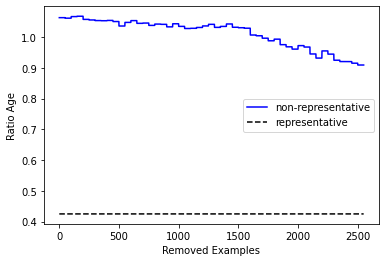

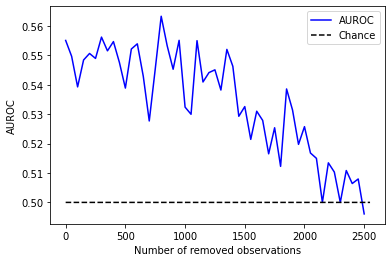

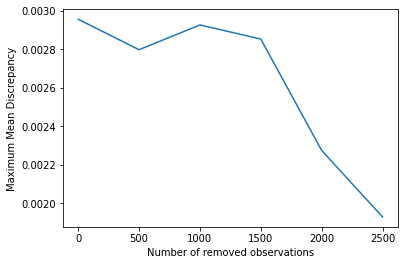

auc 0.39879783406392366


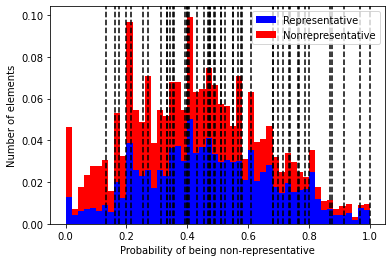

graph auc: 0.5070167414953783
auc 0.3825560569592595
graph auc: 0.5006844258513027
auc 0.40037365022998583
graph auc: 0.5032018515126792
auc 0.41031364269253573
graph auc: 0.5033816067261749
auc 0.3964706517016013
graph auc: 0.5119689060098734
auc 0.3708840575417395


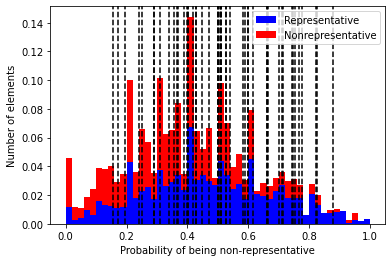

graph auc: 0.5
auc 0.3686901213441772
graph auc: 0.5030661913625231
auc 0.40692554554392657
graph auc: 0.5053969669937557
auc 0.38326687414899824
graph auc: 0.49046832009389146
auc 0.42335394973772805
graph auc: 0.4971101493787519


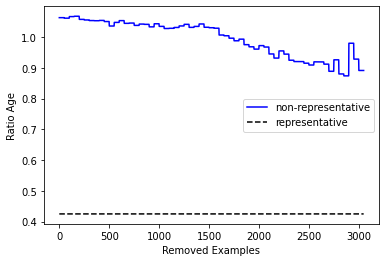

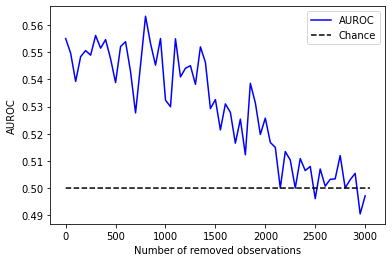

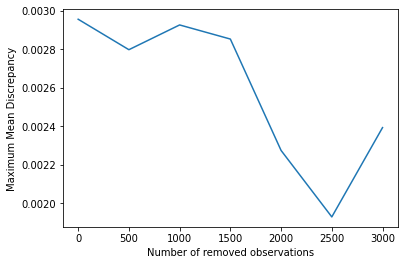

auc 0.4168373239918236


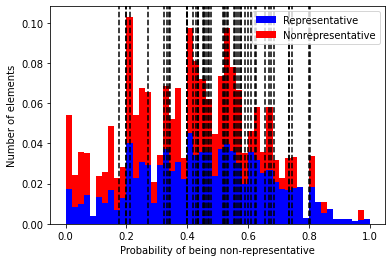

graph auc: 0.5
auc 0.4225532429566954
graph auc: 0.49680007641608553


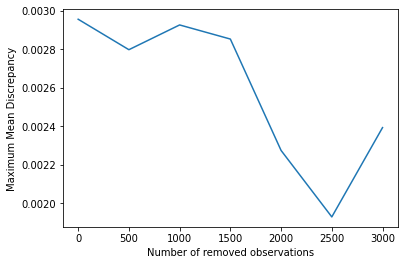

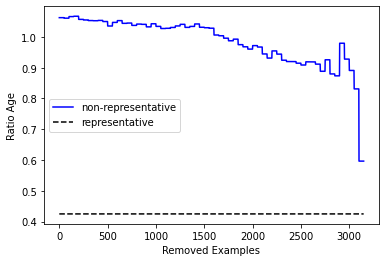

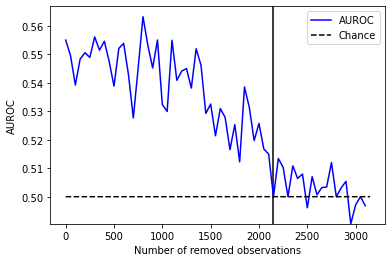

In [88]:
drop = 50
number_of_splits = 5
test_size = 0.3
mmd_iteration = 5
number_of_iterations = int(len(compas_nonrep_more_old[compas_nonrep_more_old['label'] == 1]) 
                           / drop) - 1
representative_ratio = (len(compas_rep[compas_rep[compas_bias] == 1])
                        / len(compas_rep[compas_rep[compas_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/compas_nonrep_more_old',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)
save = True
cv = 3

ratio, auc_more_old, roc, mrs, mmds, mrs_iteration = repeated_MRS(compas_nonrep_more_old, compas_columns,
                                                   number_of_splits = number_of_splits, n_drop = drop,
                                                   test_size = test_size, cv = cv, us = True, 
                                                   directory=result_dir, 
                                                   compas_bias=compas_bias, 
                                                   number_of_iterations=number_of_iterations, 
                                                                    mmd_iteration=mmd_iteration)
    

file_name = os.path.join(result_dir,  'ratio_more_old' + compas_bias)
plot_class_ratio(ratio, representative_ratio, file_name, save=save) 
plot_auc(auc_more_old, drop, file_name + '_auc', save=save, mrs_iteration=mrs_iteration)
plot_mmds(mmds, drop, mmd_iteration, f'{file_name}_mmd', save)

## Experiment 1 c)


### Simulate already representative data

| income      | Representative (R) | Second Representative (N)     |
|-------------|--------------------|------------------------|
| young (<=27Y) | 3715               | 3715                   |
| old (>27Y) | 1168               | 1168                   |

*Here we run the MRS algorithm to test whether the ratio young-old is still maintained.*

  0%|          | 0/43 [00:00<?, ?it/s]

auc 0.5100337096557519


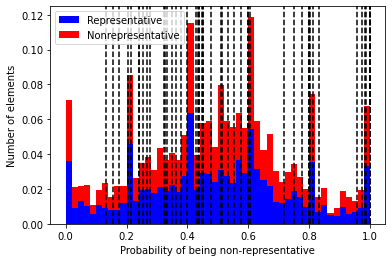

graph auc: 0.5009488257526179
auc 0.4957721180293052
graph auc: 0.496847208823972
auc 0.49794080457708584
graph auc: 0.4963180233658271
auc 0.4953080152288783
graph auc: 0.5075172101449276
auc 0.4858092233530037
graph auc: 0.4982933853586028
auc 0.5106493248934492


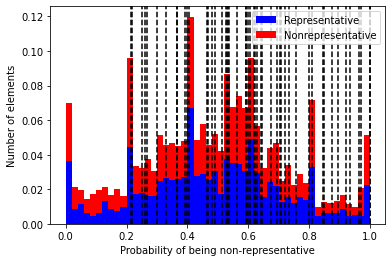

graph auc: 0.49564761755052855
auc 0.49164323294629897
graph auc: 0.5052761457109283
auc 0.4856295688293307
graph auc: 0.49434846830160917
auc 0.4807325239187872
graph auc: 0.49964508999275825
auc 0.48301653032752834
graph auc: 0.493683674933912


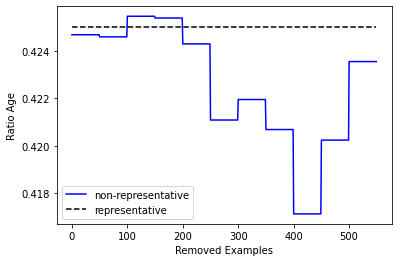

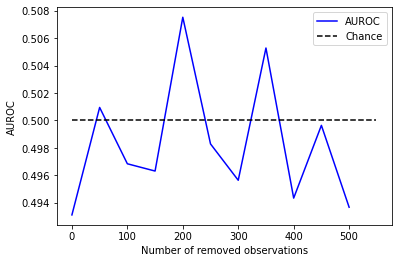

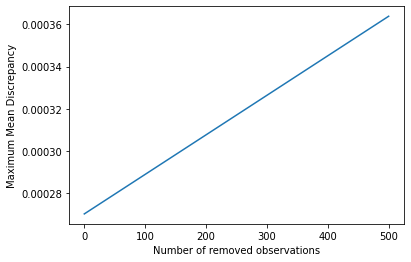

auc 0.48946834733607253


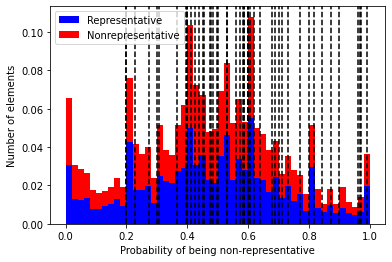

graph auc: 0.5002407048979883
auc 0.469110267057211
graph auc: 0.49855657513102775
auc 0.47615257484011303
graph auc: 0.5006428237494156
auc 0.4642989065158876
graph auc: 0.49736751662636947
auc 0.4558433196044221
graph auc: 0.4954278693534405
auc 0.4588194969884389


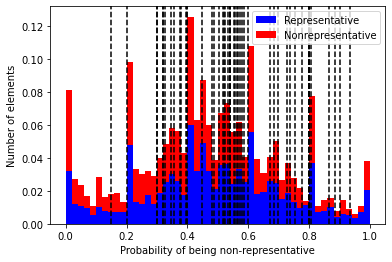

graph auc: 0.49277990363747026
auc 0.4643716997672005
graph auc: 0.5003428854615224
auc 0.45624518976188383
graph auc: 0.4958748611088145
auc 0.4440807340593196
graph auc: 0.4915141611412788
auc 0.43858737670803205
graph auc: 0.4948498015678773


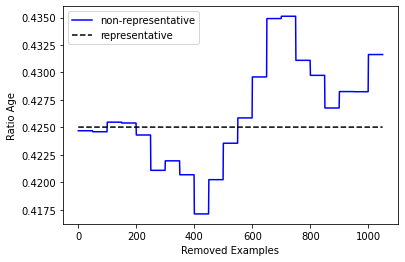

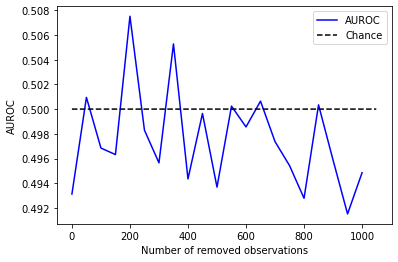

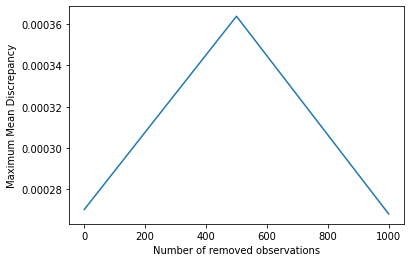

auc 0.4446493063759409


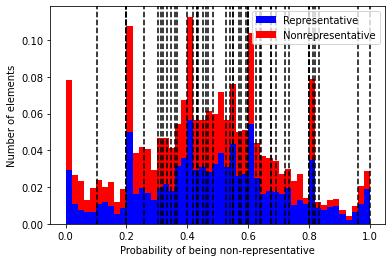

graph auc: 0.4999190766885867
auc 0.43299556914423987
graph auc: 0.49132305721395075
auc 0.4225057056014808
graph auc: 0.494870476128029
auc 0.4188673737204044
graph auc: 0.49270706359310523
auc 0.4078833432597621
graph auc: 0.4966611026602984
auc 0.40940939227696077


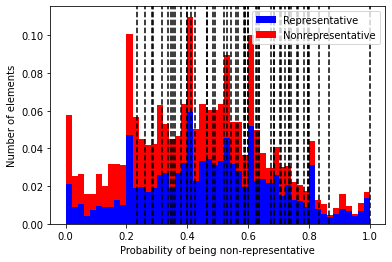

graph auc: 0.4963732113297814
auc 0.4015687414105347
graph auc: 0.4888138464986181
auc 0.38858989371284447
graph auc: 0.48626186524923626
auc 0.3906894229866632
graph auc: 0.4796995361968139
auc 0.3794953763767887
graph auc: 0.4834560677188202


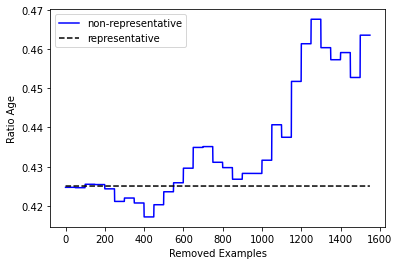

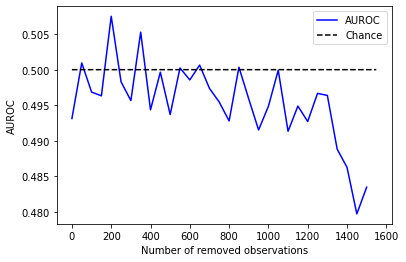

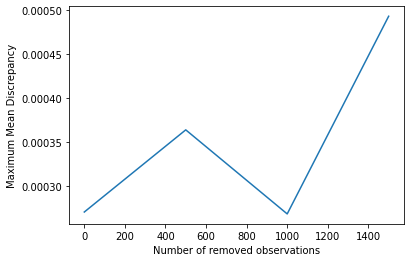

auc 0.3988614201246866


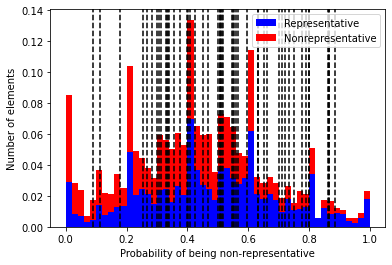

graph auc: 0.49948878513736295
auc 0.3940596108351864
graph auc: 0.4980434782608696
auc 0.3725943516373667
graph auc: 0.4971112624374481
auc 0.37138858178807777
graph auc: 0.49007924385905016
auc 0.37919719169719174
graph auc: 0.49136473429951694
auc 0.3957848474773502


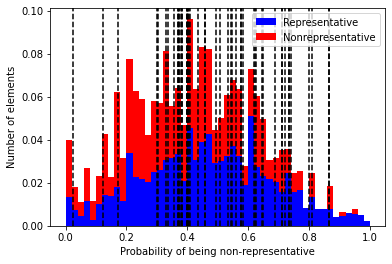

graph auc: 0.4973785037305909
auc 0.377899614163158
graph auc: 0.48945067866363334
auc 0.35629658556985067
graph auc: 0.4908363333432507
auc 0.3874871094645176
graph auc: 0.4843421942279635
auc 0.3514686639315223
graph auc: 0.49539286819202727


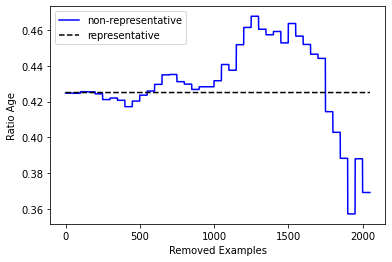

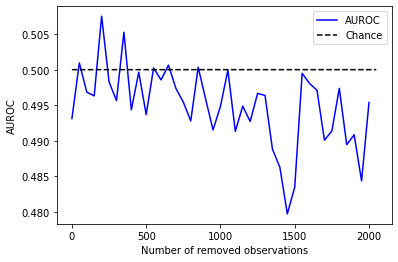

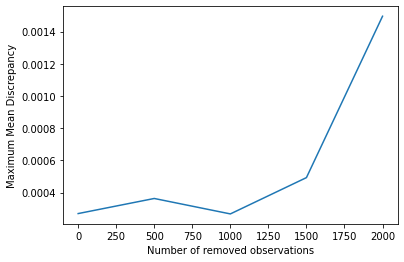

auc 0.38115502006317764


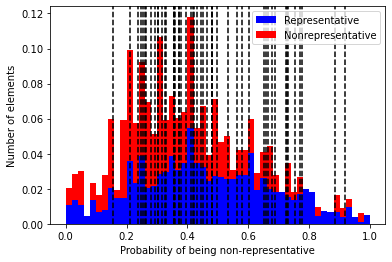

graph auc: 0.5036980466331633
auc 0.4180960548885077
graph auc: 0.4605071453934687
auc 0.38544050742436087
graph auc: 0.47074473229892233


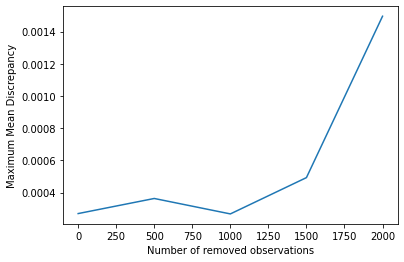

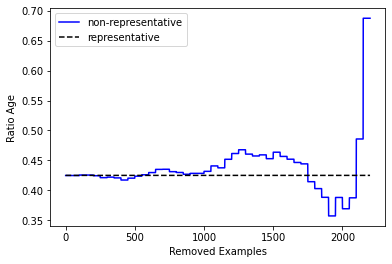

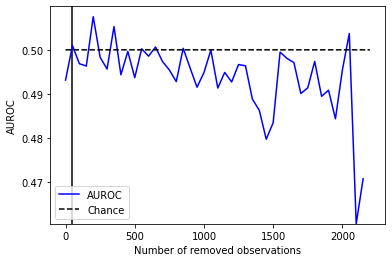

In [87]:
drop = 50
number_of_splits = 5
test_size = 0.3
number_of_iterations = int(len(compas_rep[compas_rep['label'] == 1]) 
                           / drop) - 1
representative_ratio = (len(compas_rep[compas_rep[compas_bias] == 1]) / len(compas_rep[compas_rep[compas_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/compas_rep',  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)
cv = 3
mmd_iteration = 5
save = True

ratio, auc_rep, roc, new_rep, mmds, mrs_iteration = repeated_MRS(compas_rep, compas_columns,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = cv, us = True, directory=result_dir, 
                                            compas_bias=compas_bias, 
                                            number_of_iterations=number_of_iterations, 
                                                                    mmd_iteration=mmd_iteration)
    
file_name = os.path.join(result_dir, 'ratio_rep'  + compas_bias)
plot_class_ratio(ratio, representative_ratio, file_name, save=True) 
plot_auc(auc_rep, drop, file_name + '_auc', save=True, mrs_iteration=mrs_iteration)
plot_mmds(mmds, drop, mmd_iteration, f'{file_name}_mmd', save)

## Experiment 2
### <font color='darkgreen'>Allensbach</font>   <---MRS---> <font color='darkred'>GBS</font> <---MRS---> <font color='darkgreen'>GESIS</font> 

*Figure shows MRS concept on GBS and GESIS for experiment 2 a). Replace Allensbach with GESIS for experiment 2 b)*

<img src="overview.PNG" width="450" height="450"/>


**Multivariate auxiliary information GESIS linked to GBS so that expected selection bias can be detected and corrected for. In addition, GBS contains an attribute for positive and negative treatment of survey participents for further analysis (Experiment 4).**


## Experiment 2 a)
### <font color='darkgreen'>Allensbach Studie - Institut für Demoskopie(IfD)</font>  <a name="us"></a>

### <font color='darkred'>Important note:</font>  <a name="allensbach"></a> Allensbach is already merged with GBS in this data set


In [13]:
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
allensbach_columns = ['Alter', 'BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Berufsgruppe', 'Erwerbstaetigkeit', 'Geschlecht',
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']

scaler = StandardScaler()
scaled_allensbach = allensbach.copy(deep=True)
scaled_allensbach[allensbach_columns] = scaler.fit_transform(scaled_allensbach[allensbach_columns])

  0%|          | 0/3 [00:00<?, ?it/s]

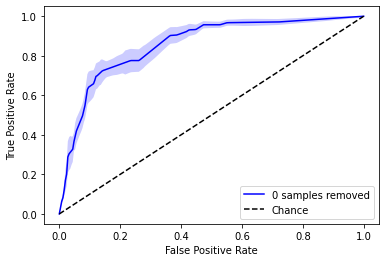

  0%|          | 0/28 [00:00<?, ?it/s]

auc 0.8771604257768958


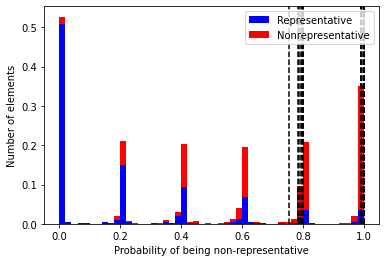

graph auc: 0.856867717907541
auc 0.8555400664814321
graph auc: 0.8609343491894288
auc 0.860547507204042
graph auc: 0.8531927639023824
auc 0.860319388075814
graph auc: 0.8261026065969428
auc 0.8582652894441365
graph auc: 0.8466986039952389


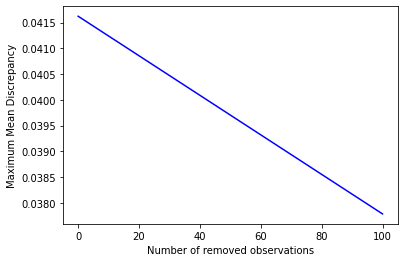

auc 0.8398323561201676


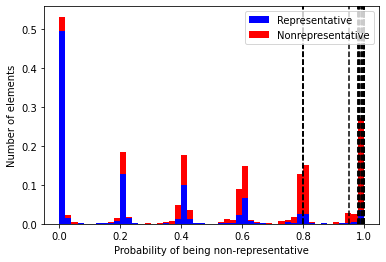

graph auc: 0.8421935784919624
auc 0.8439445912328682
graph auc: 0.8384972343206247
auc 0.8301709236013507
graph auc: 0.836401906262499
auc 0.842733881751553


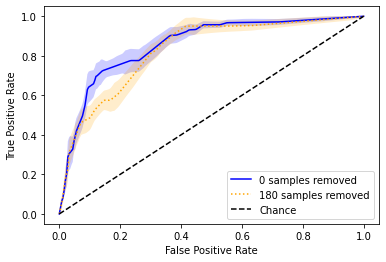

graph auc: 0.8305955002302629
auc 0.8233960344122718
graph auc: 0.8142266470009834


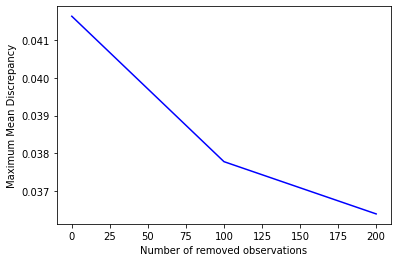

auc 0.8373916989464623


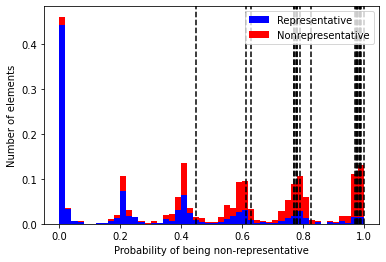

graph auc: 0.7906872737023034
auc 0.8280203579683518
graph auc: 0.8077355686429902
auc 0.8242405698863992
graph auc: 0.7808161873156342
auc 0.8134045888081104
graph auc: 0.7825355632218389
auc 0.8236349296710073
graph auc: 0.7864220172649375


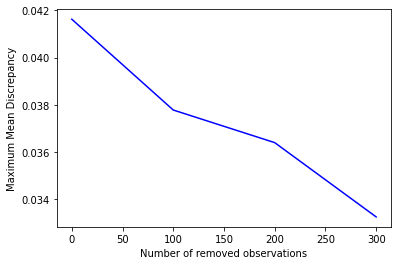

auc 0.8111177838785937


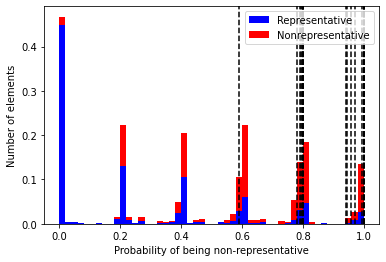

graph auc: 0.7806258581490232
auc 0.7845967167775677
graph auc: 0.7540492138956882
auc 0.792378853971928


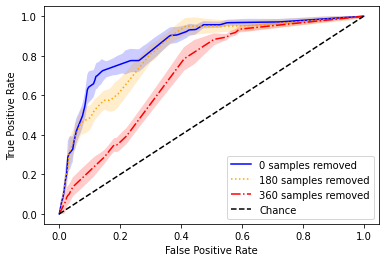

graph auc: 0.7140344357341682
auc 0.7688720489653162
graph auc: 0.6736964601769911
auc 0.7630706725114936
graph auc: 0.6813737806495919


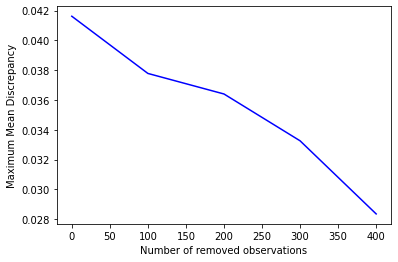

auc 0.7286119695709022


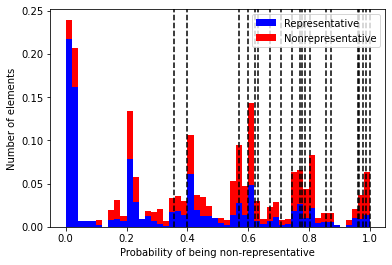

graph auc: 0.6924500586798616
auc 0.725938378161381
graph auc: 0.6256967270684084
auc 0.7033235114036429
graph auc: 0.5889645590184259
auc 0.7034499970200846
graph auc: 0.5705732546705998
auc 0.6734991761587505
graph auc: 0.5


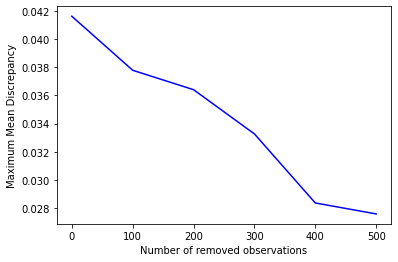

auc 0.6790443486848011


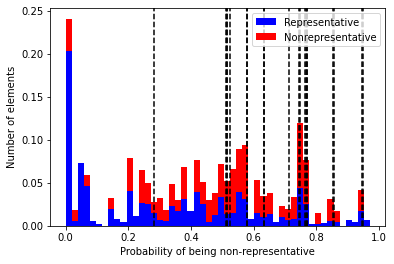

graph auc: 0.5587556985787074
auc 0.6718130183916335


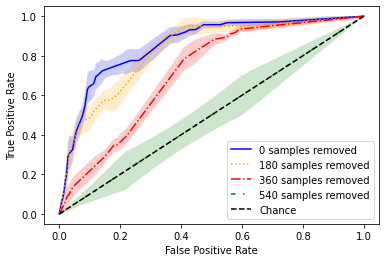

graph auc: 0.5189159292035399
auc 0.6499704491725768
graph auc: 0.5203539823008849


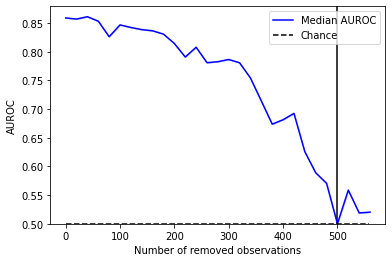

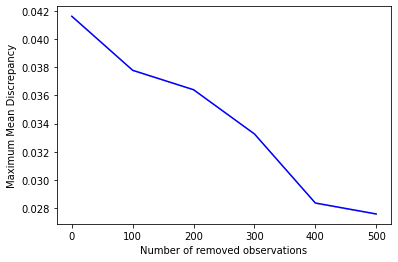

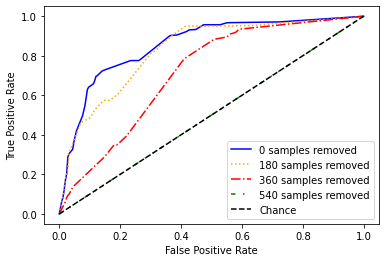

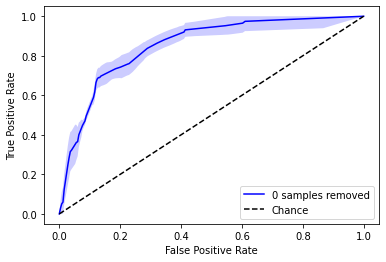

  0%|          | 0/28 [00:00<?, ?it/s]

auc 0.8598234299783192


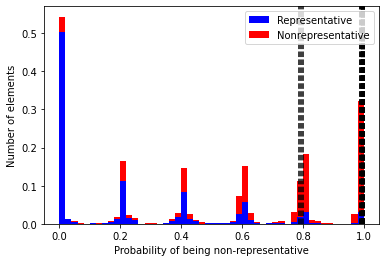

graph auc: 0.8686447743571637
auc 0.8583614039761986
graph auc: 0.8395978801700276
auc 0.8630500072369373
graph auc: 0.8100861541252039
auc 0.8594209062709247
graph auc: 0.8337302386698848
auc 0.8546916528091644
graph auc: 0.8346649038710346


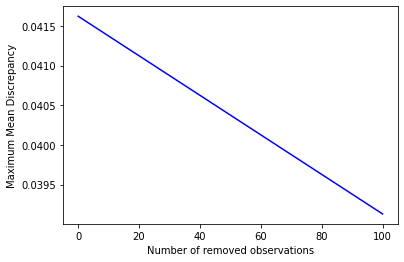

auc 0.8440752750262811


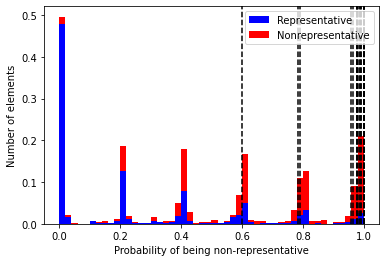

graph auc: 0.8208940052081644
auc 0.8549585515845424
graph auc: 0.8138784657684568
auc 0.8382667732919757
graph auc: 0.8103966059490103
auc 0.8385900658440393


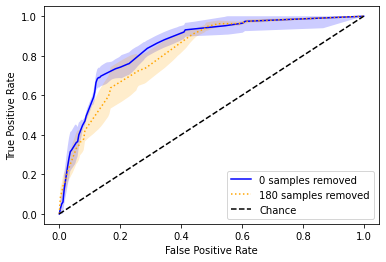

graph auc: 0.8168545623140784
auc 0.8224317442542526
graph auc: 0.8026126119132639


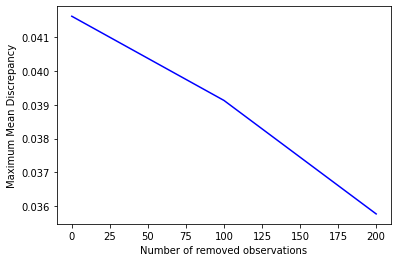

auc 0.8173197477497708


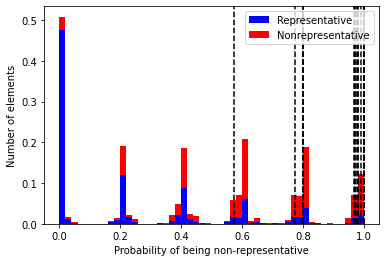

graph auc: 0.7898580758559882
auc 0.8221616389102906
graph auc: 0.7939235654108427
auc 0.8113388878428418
graph auc: 0.7808061174322236
auc 0.8124027323862246
graph auc: 0.7480193884750207
auc 0.8038749140159871
graph auc: 0.7517564488117585


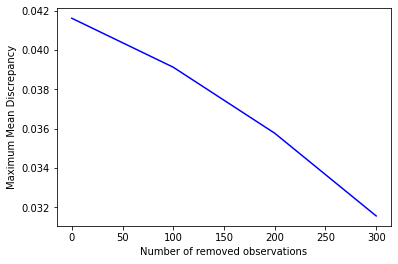

auc 0.8044974452833066


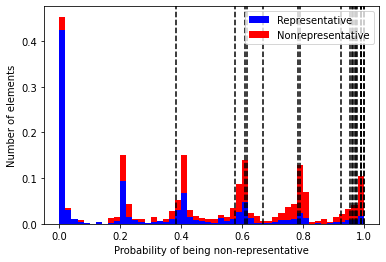

graph auc: 0.7561954711087976
auc 0.794463156165284
graph auc: 0.6571335697399527
auc 0.7820168996112644


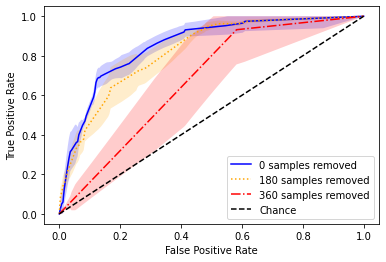

graph auc: 0.6388413482426655
auc 0.7584381780498074
graph auc: 0.646133628318584
auc 0.7642423108450052
graph auc: 0.5375555555555556


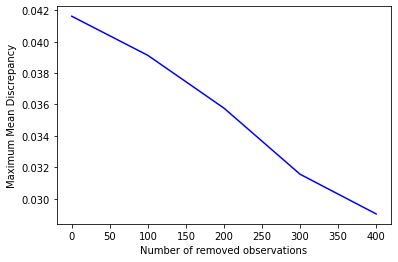

auc 0.7426056896073537


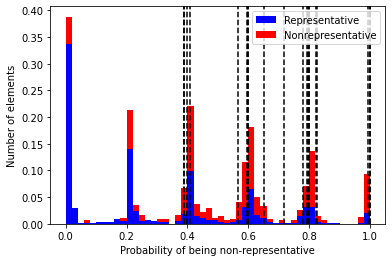

graph auc: 0.5587781901227519
auc 0.7368972746331237
graph auc: 0.601183359086014
auc 0.7295015051788356
graph auc: 0.5246681415929204
auc 0.7020233625365039
graph auc: 0.5113646949231485
auc 0.6665278673257397
graph auc: 0.5601111111111111


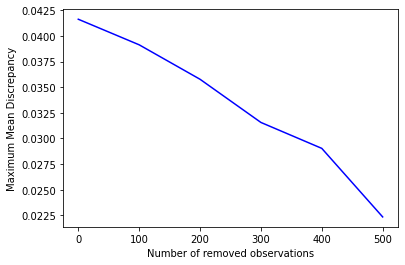

auc 0.6437124068587845


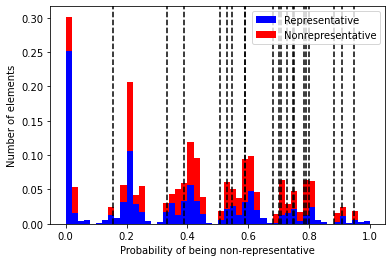

graph auc: 0.5135156878519711
auc 0.6422271306647434


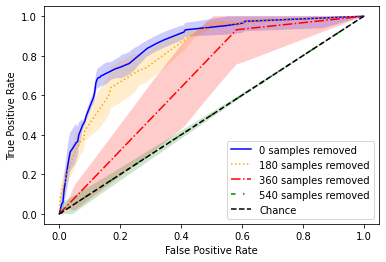

graph auc: 0.5101071779744346
auc 0.535597381342062
graph auc: 0.5


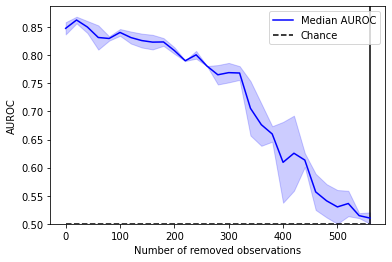

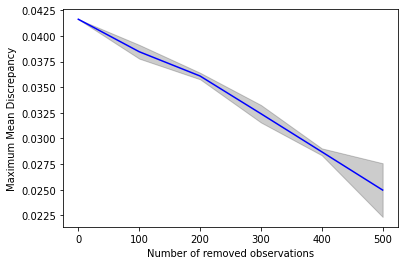

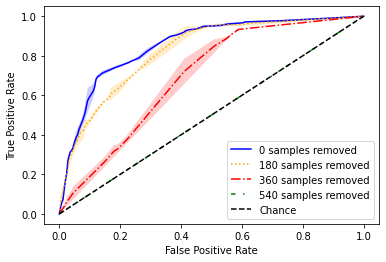

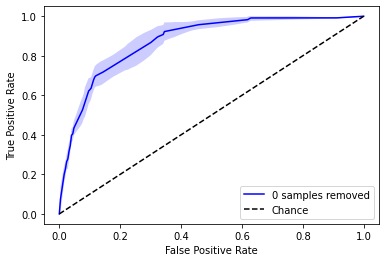

  0%|          | 0/28 [00:00<?, ?it/s]

auc 0.8655115814745403


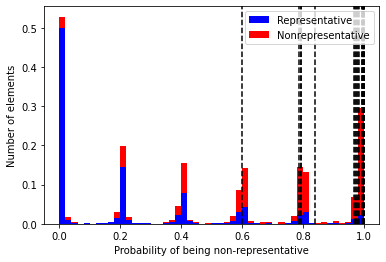

graph auc: 0.8640052239344275
auc 0.8740238711478195
graph auc: 0.8555104662414278
auc 0.8540918301556598
graph auc: 0.8435114333404565
auc 0.8627987537408273
graph auc: 0.8513279681773487
auc 0.859199782543811
graph auc: 0.829651938967379


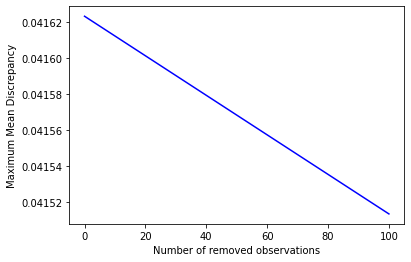

auc 0.8642571329157968


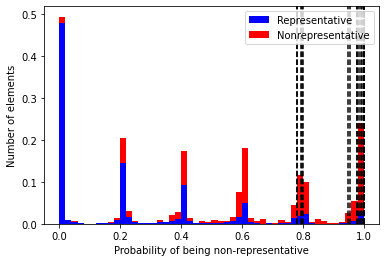

graph auc: 0.8405142256742874
auc 0.8518257775923609
graph auc: 0.8262226329514245
auc 0.8438221942196159
graph auc: 0.8117514398089618
auc 0.8199656392288291


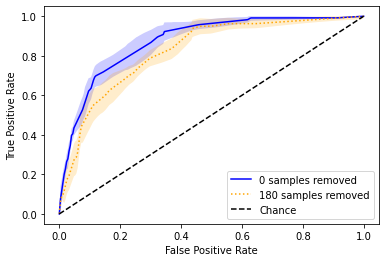

graph auc: 0.8216362256201535
auc 0.8459124317886916
graph auc: 0.7984629974641619


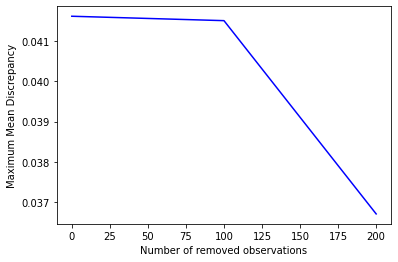

auc 0.8374782462246674


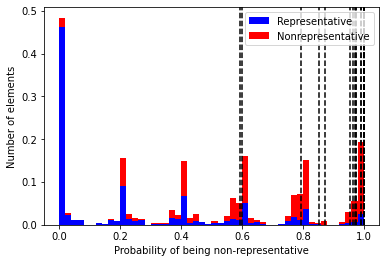

graph auc: 0.7821772681318987
auc 0.81775370908157
graph auc: 0.7822117121316892
auc 0.8206055566016026
graph auc: 0.784709742414665
auc 0.8169270659641165
graph auc: 0.7443372481375932
auc 0.797437972912071
graph auc: 0.7540797673319797


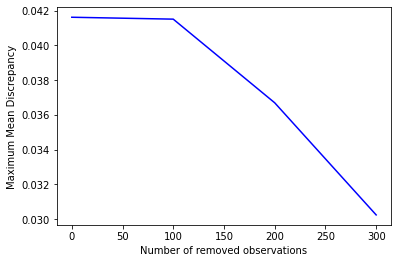

auc 0.8119915986679884


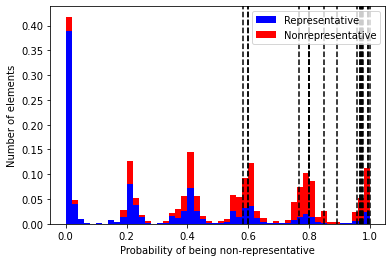

graph auc: 0.6942448755767339
auc 0.7856081765656234
graph auc: 0.7311875222284986
auc 0.7782816255675242


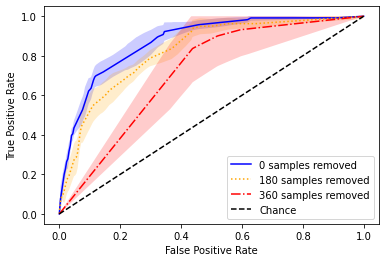

graph auc: 0.6688013953072607
auc 0.7721185919233137
graph auc: 0.5615378942591331
auc 0.7584598524537581
graph auc: 0.6412252813285261


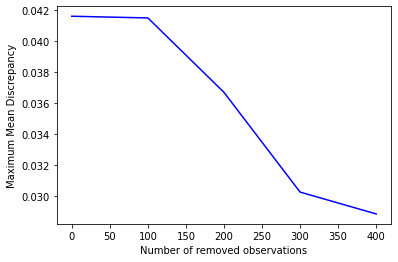

auc 0.7495864535044969


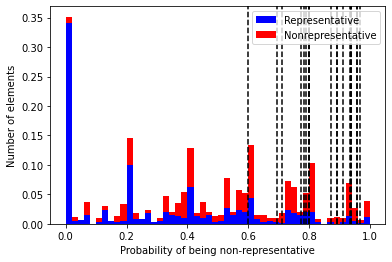

graph auc: 0.6280252997430774
auc 0.7543127481154378
graph auc: 0.5646316898440793
auc 0.7291570998520333
graph auc: 0.6225747295968536
auc 0.6825794147446212
graph auc: 0.6146697200227708
auc 0.7220789454832008
graph auc: 0.5230277777777778


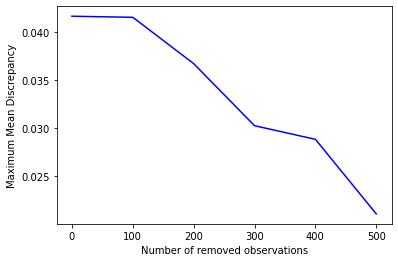

auc 0.6612970194811024


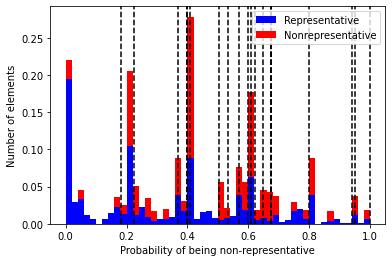

graph auc: 0.5267037037037037
auc 0.6534439235485034


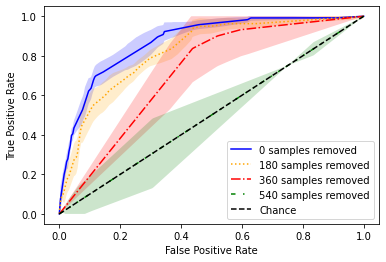

graph auc: 0.5343333333333333
auc 0.6579264411711221
graph auc: 0.5095


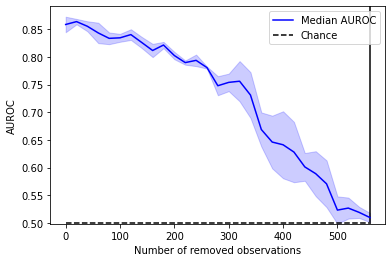

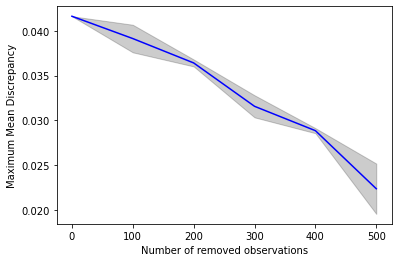

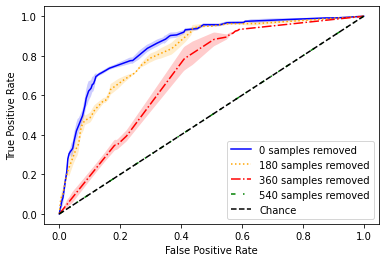

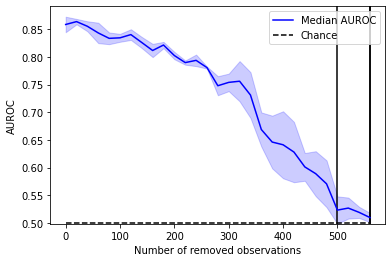

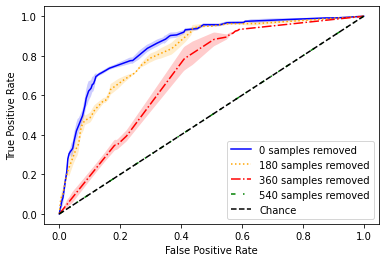

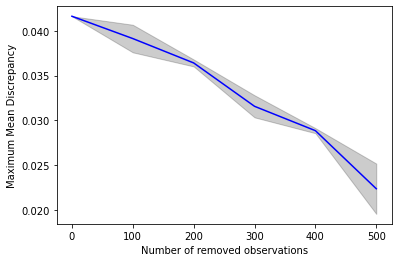

In [59]:
drop = 20
number_of_splits = 5
cv = 5
result_dir_allensbach = os.path.join(os.getcwd(), 'results/gbs_allensbach', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir_allensbach, exist_ok=True)

test_size = 0.3
number_of_iterations = int((len(scaled_allensbach[scaled_allensbach['label']  == 1]) -
                           number_of_splits)/drop)

aucs = []
rocs = []
mmds = []
mmd_iteration = 5
mrs_iterations = []

for _ in tqdm(range(3)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_allensbach, allensbach_columns,
                     number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=cv, directory=result_dir_allensbach)
    aucs.append(auc)
    rocs.append(roc)
    mmds.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)
    
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iteration)
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=False)
    plot_rocs(median_rocs, '', save=False)
     
plot_auc_median(median_aucs, std_aucs, drop, result_dir_allensbach + "/median_aucs" , 
                save=True, mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_allensbach + "/median_rocs", save=True)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_allensbach + "/median_mmds", save=True)

    
pickle.dump(median_aucs, open(result_dir_allensbach + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_allensbach + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_allensbach + "/median_roc", 'wb'))
pickle.dump(median_mmds, open(result_dir_allensbach + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_allensbach + "/std_mmds", 'wb'))

### Save results

In [60]:
pickle.dump(median_aucs, open("results/allensbach_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/allensbach_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/allensbach_median_rocs", 'wb'))

pickle.dump(median_mmds, open("results/allensbach_median_mmds", 'wb'))
pickle.dump(std_mmds, open("results/allensbach_std_mmds", 'wb'))
pickle.dump(mrs_iterations, open("results/allensbach_mrs_iterations", 'wb'))

### Load  results

In [68]:
allensbach_median_aucs = pickle.load(open("results/allensbach_median_aucs", "rb"))
allensbach_std_aucs = pickle.load(open("results/allensbach_std_aucs", "rb"))
allensbach_rocs = pickle.load(open("results/allensbach_median_rocs", "rb"))
allensbach_mrs_iterations =  pickle.load(open("results/allensbach_mrs_iterations", 'rb'))
allensbach_median_mmds =  pickle.load(open("results/allensbach_median_mmds", 'rb'))
allensbach_std_mmds =  pickle.load(open("results/allensbach_std_mmds", 'rb'))

### Visualise results

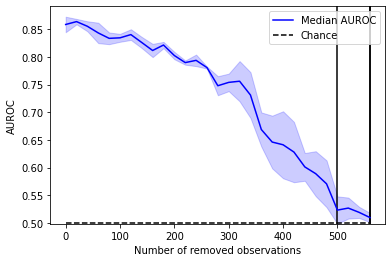

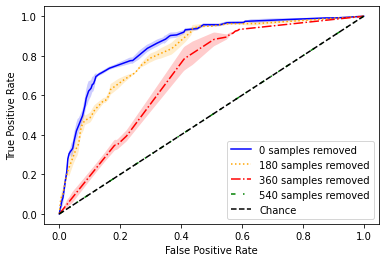

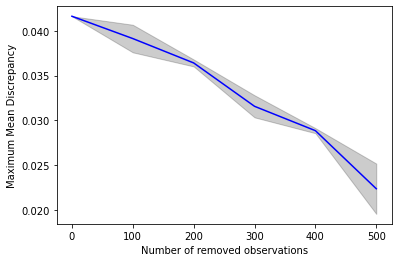

In [69]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/allensbach/")
os.makedirs(file_directory, exist_ok=True)

plot_auc_median(allensbach_median_aucs, allensbach_std_aucs, drop, file_directory+"allensbach_auc", save=save, 
                mrs_iteration=allensbach_mrs_iterations)
plot_rocs(allensbach_rocs, file_directory+"allensbach_rocs", save=save)
plot_mmds_median(allensbach_median_mmds, allensbach_std_mmds, drop, mmd_iteration, 
                 file_directory + "median_mmds", save=save)


### <font color='darkgreen'>Load Gesis</font>  <a name="us"></a>

In [14]:
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

gesis_columns = ['Geschlecht', 'Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Berufsgruppe',
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll']

N = gbs.copy()
R = gesis.copy()

N['label'] = 1
R['label'] = 0

gesis_gbs = pd.concat([N, R], ignore_index=True)

In [15]:
scaler = StandardScaler()
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_gbs[gesis_columns] = scaler.fit_transform(scaled_gesis_gbs[gesis_columns])

### Experiment 2 b)

  0%|          | 0/1 [00:00<?, ?it/s]

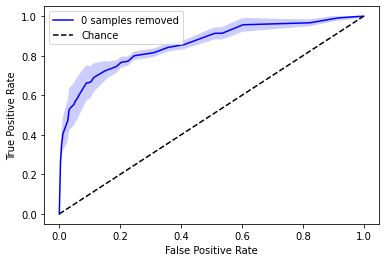

  0%|          | 0/27 [00:00<?, ?it/s]

auc 0.8831648287862917


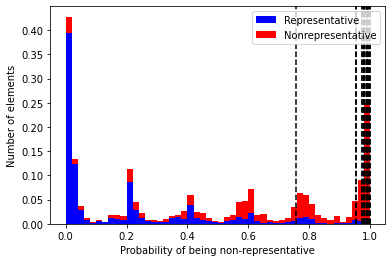

graph auc: 0.8467229913309989
auc 0.8815320536327393
graph auc: 0.8377673318905895
auc 0.8866469072063665
graph auc: 0.8447805713423209
auc 0.8742233806798472
graph auc: 0.8400756894238581
auc 0.8803087464644516
graph auc: 0.844133527971352


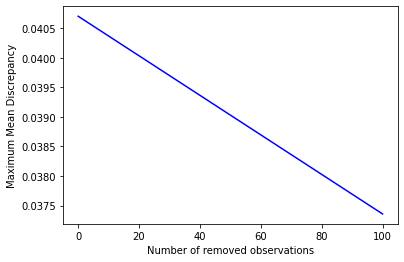

auc 0.8750694624941839


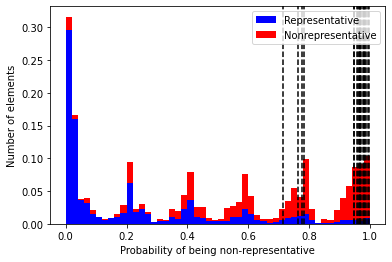

graph auc: 0.8086843971264954
auc 0.8609904880861369
graph auc: 0.8252418245087506
auc 0.8600429097346234


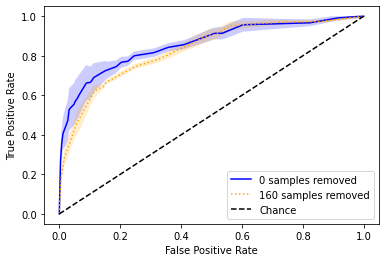

graph auc: 0.8330137303874959
auc 0.8622618490606522
graph auc: 0.8242883966244726


In [ ]:
drop = 20
number_of_splits = 5
result_dir_gesis = os.path.join(os.getcwd(), 'results/gbs_gesis',  
                                datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.3
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) 
                           / drop) - 1

os.makedirs(result_dir_gesis, exist_ok=True)
aucs = []
rocs = []
mmds = []
mmd_iteration = 5
mrs_iterations = []

for _ in tqdm(range(3)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_gesis_gbs, gesis_columns, 
                                                     number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=5, directory=result_dir_gesis,
                                             number_of_iterations=number_of_iterations)
    aucs.append(auc)
    rocs.append(roc)
    mmds.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis=0)
    plot_rocs(median_rocs, '', save=False)
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=False)
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iterations)
    

plot_auc_median(median_aucs, std_aucs, drop, result_dir_gesis + "/median_aucs", save=True,
               mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_gesis + "/median_rocs", save=True)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_gesis + "/median_mmds", save=True)

pickle.dump(median_aucs, open(result_dir_gesis + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_gesis + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_gesis + "/median_rocs", 'wb'))
pickle.dump(median_mmds, open(result_dir_gesis + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_gesis + "/std_mmds", 'wb'))
pickle.dump(mrs_iterations, open(result_dir_gesis + "/mrs_iterations", 'wb'))

### Save results

In [37]:
pickle.dump(median_aucs, open("results/gesis_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/gesis_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/gesis_median_rocs", 'wb'))
pickle.dump(median_mmds, open("results/gesis_median_mmds", 'wb'))
pickle.dump(std_mmds, open("results/gesis_std_mmds", 'wb'))
pickle.dump(mrs_iterations, open("results/gesis_mrs_iterations", 'wb'))

### Load results

In [38]:
gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
gesis_median_rocs =  pickle.load(open("results/gesis_median_rocs", 'rb'))
gesis_mrs_iterations =  pickle.load(open("results/gesis_mrs_iterations", 'rb'))
gesis_median_mmds =  pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds =  pickle.load(open("results/gesis_std_mmds", 'rb'))

### Visualise results

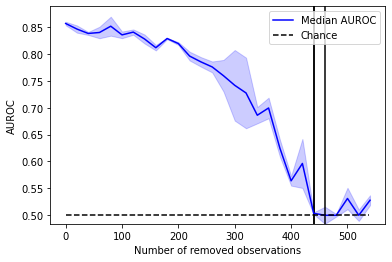

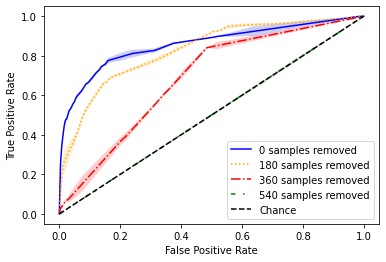

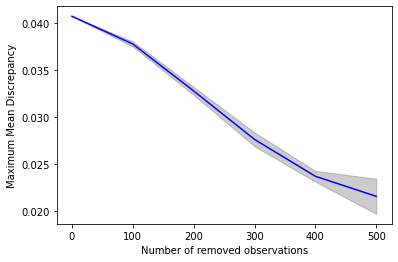

In [58]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/gesis/")
os.makedirs(file_directory, exist_ok=True)

plot_auc_median(gesis_median_aucs, gesis_std_aucs, drop, file_directory+"gesis_auc", save=save, 
                mrs_iteration=gesis_mrs_iterations)
plot_rocs(gesis_median_rocs, file_directory+"gesis_rocs", save=save)
plot_mmds_median(gesis_median_mmds, gesis_std_mmds, drop, mmd_iteration, 
                 file_directory + "median_mmds", save=save)

### Experiment 2 c)
### <font color='darkgreen'> Comparison with a third independent dataset (Allensbach) </font>

In [23]:
def repeated_MRS_with_third_dataset(df, columns, comparing_dataset, comparing_dataset_columns,
                                    number_of_splits, number_of_iterations,
                                    n_drop=1, test_size=0.33, cv=5, directory=''):

    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    C = comparing_dataset.copy()
    aucs = []
    comparison_aucs = []
    mmds = []
    comparison_mmds = []
    mmd_iteration = 5

    #start value
    auc, _ = auc_prediction(N, R, columns, test_size, drop, 0, cv, calculate_roc=False)
    aucs.append(auc)
    mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    # start value checking
    auc, _ = auc_prediction(N, C, comparing_dataset_columns, test_size, drop, 0, cv, calculate_roc=False)
    comparison_aucs.append(auc)
    comparison_mmds.append(maximum_mean_discrepancy(N[comparing_dataset_columns],
                                                     C[comparing_dataset_columns]))
    
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS_with_histogram(N, R, columns,
                                number_of_splits=number_of_splits,
                                n_drop=n_drop, cv=cv, directory=directory, iteration=i)
        
        # auc
        auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
        aucs.append(auc)
        
        # auc check
        auc, _ = auc_prediction(N, C, comparing_dataset_columns, test_size, drop, i+1, cv, 
                                calculate_roc=False)
        comparison_aucs.append(auc)
        
        if ((i+1) % mmd_iteration == 0):
            mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
            plot_mmds(mmds, drop, mmd_iteration, '', False)
            comparison_mmds.append(maximum_mean_discrepancy(N[comparing_dataset_columns],
                                                             C[comparing_dataset_columns]))
            plot_mmds(comparison_mmds, drop, mmd_iteration, '', False)
           
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    return aucs, comparison_aucs, mmds, comparison_mmds

In [37]:
gesis_columns = ['Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung',  
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll']

allensbach_columns = ['Alter', 'BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']

all_columns = ['Erwerbstaetigkeit', 'Geschlecht']

allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

gbs['label'] = 1
gesis['label'] = 0
gesis_gbs = pd.concat([gbs, gesis])

In [38]:
# create scaler
scaled_allensbach_gbs = allensbach.copy(deep=True)
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_checking = gesis.copy(deep=True)
scaled_allensbach_checking = allensbach[allensbach['label']==0].copy(deep=True)

# create scaler
scaler_allensbach = StandardScaler()
all_scaler = StandardScaler()
scaler_gesis = StandardScaler()

# fit scaler
scaler_allensbach = scaler_allensbach.fit(allensbach[allensbach_columns])
all_scaler = all_scaler.fit(pd.concat([scaled_allensbach_checking[all_columns], 
                                       gesis[all_columns], gbs[all_columns]]))
scaler_gesis = scaler_gesis.fit(gesis_gbs[gesis_columns])



# transform datasets
scaled_allensbach_gbs[all_columns] = all_scaler.transform(scaled_allensbach_gbs[all_columns])
scaled_allensbach_gbs[allensbach_columns] = scaler_allensbach.transform(
    scaled_allensbach_gbs[allensbach_columns])
scaled_allensbach_gbs[gesis_columns] = scaler_gesis.transform(scaled_allensbach_gbs[gesis_columns])

scaled_allensbach_checking[all_columns] = all_scaler.transform(scaled_allensbach_checking[all_columns])
scaled_allensbach_checking[allensbach_columns] = scaler_allensbach.transform(
    scaled_allensbach_checking[allensbach_columns])

scaled_gesis_checking[all_columns] = all_scaler.transform(scaled_gesis_checking[all_columns])
scaled_gesis_checking[gesis_columns] = scaler_gesis.transform(scaled_gesis_checking[gesis_columns])

scaled_gesis_gbs[gesis_columns] = scaler_gesis.transform(scaled_gesis_gbs[gesis_columns])
scaled_gesis_gbs[all_columns] = all_scaler.transform(scaled_gesis_gbs[all_columns])
scaled_gesis_gbs[allensbach_columns] = scaler_allensbach.transform(scaled_gesis_gbs[allensbach_columns])

### Create with allensbach

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

auc 0.8468570474895576


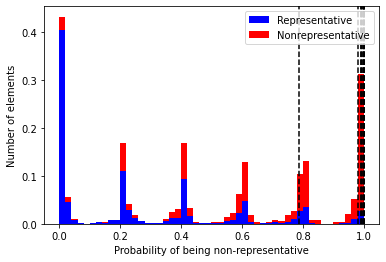

auc 0.8153216106395443
auc 0.8309259188774281
auc 0.8273618054748155
auc 0.8117483453729655


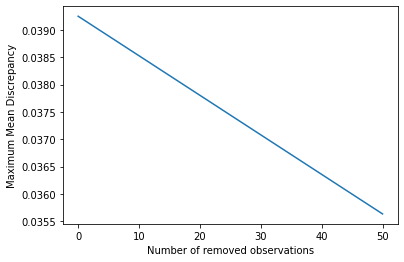

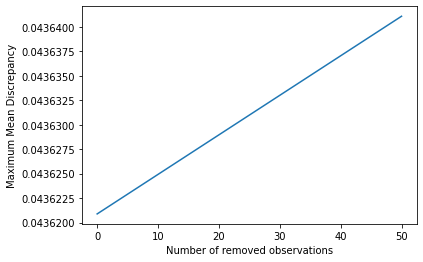

auc 0.8302103862499832


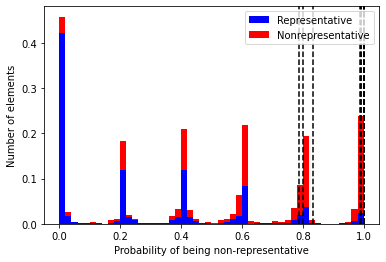

auc 0.8224106300987988
auc 0.8308418328247571
auc 0.8173403544678008
auc 0.8002826364414278


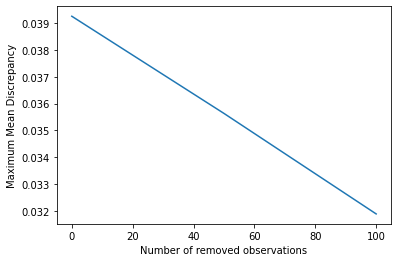

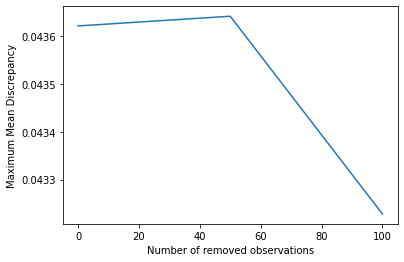

auc 0.8285749714979493


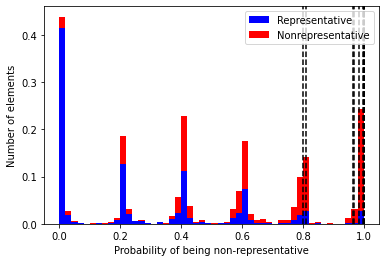

auc 0.8160470444131924
auc 0.8107762017336485
auc 0.8071897360564848
auc 0.8033217418698202


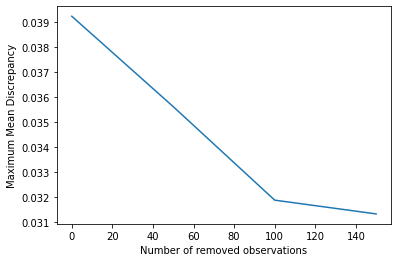

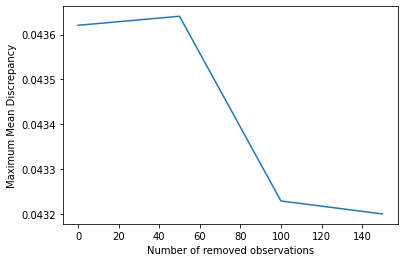

auc 0.7894245234670765


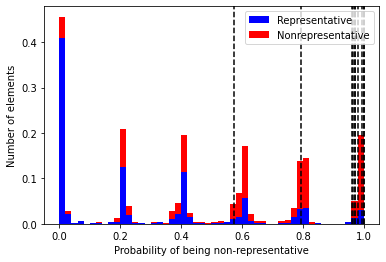

auc 0.7896979045007533
auc 0.7981953042362447
auc 0.7830580440462859
auc 0.7895244215938304


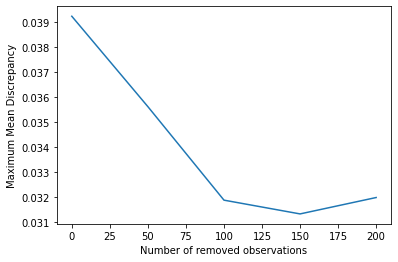

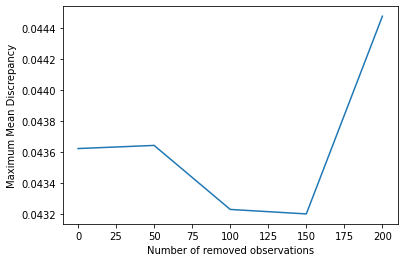

auc 0.7841101536331144


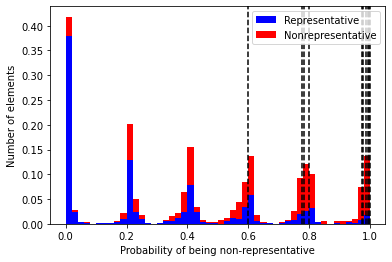

auc 0.7794943685252455
auc 0.769371431675853
auc 0.7707672885041353
auc 0.7587227243247767


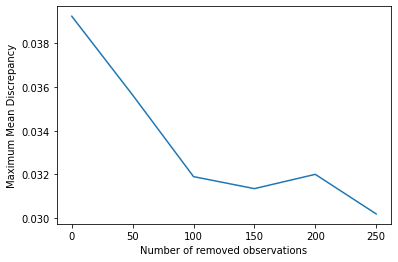

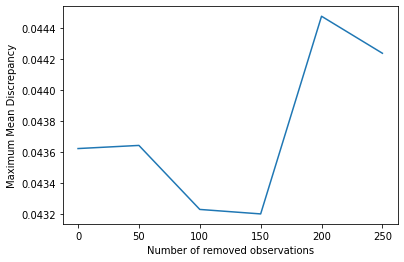

auc 0.7705436633684709


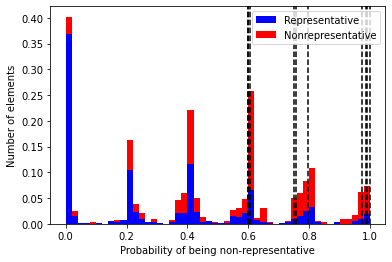

auc 0.7689282776406767
auc 0.7568325529619684
auc 0.7465309898242369
auc 0.7500337431593413


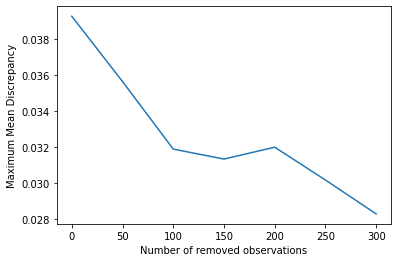

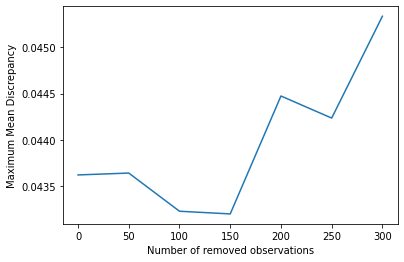

auc 0.7487432954574341


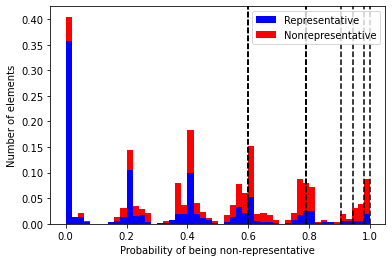

auc 0.7329170950987371
auc 0.7478350310797118
auc 0.7401218348571591
auc 0.7486127184782931


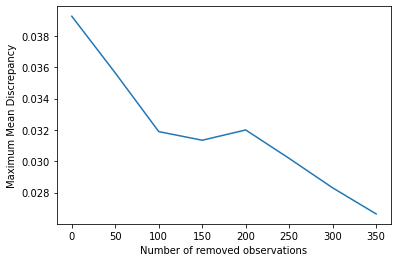

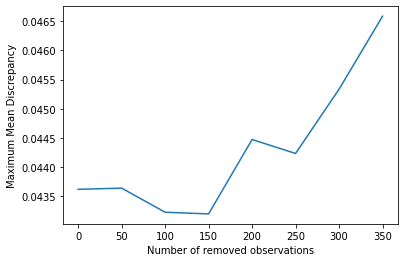

auc 0.7246430672984607


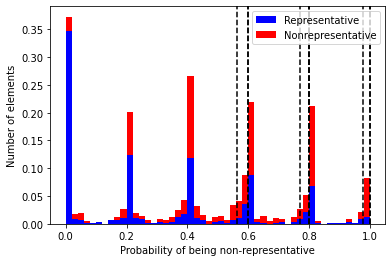

auc 0.7095821593963534
auc 0.722443499949099
auc 0.6946389750169285
auc 0.7088891703253405


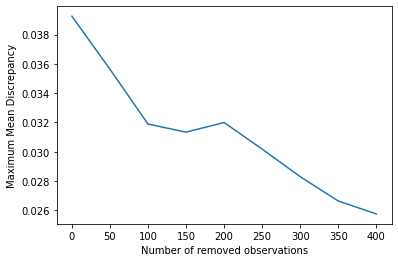

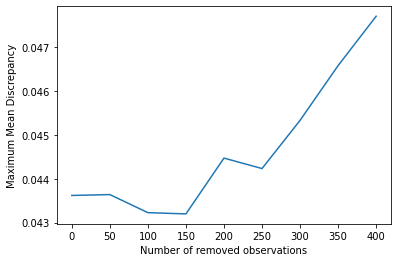

auc 0.7184887475732001


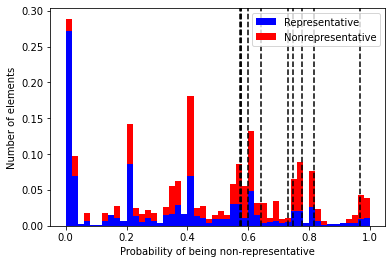

auc 0.7317423097905913
auc 0.7169783442615638
auc 0.6905433385691847
auc 0.6775409459666311


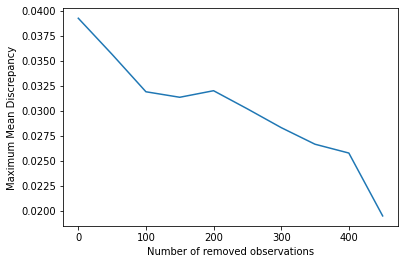

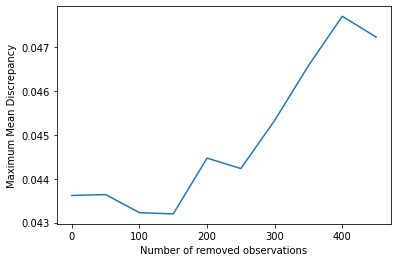

auc 0.6742261806586398


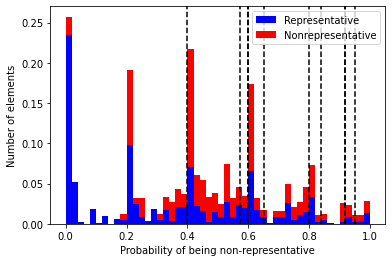

auc 0.6928824721377914
auc 0.6332308543171319
auc 0.6919773980944194
auc 0.6788090684516694


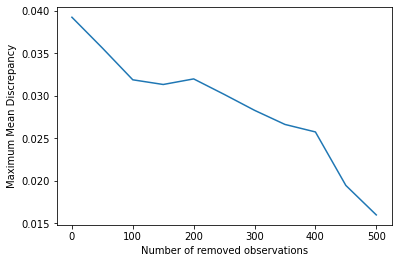

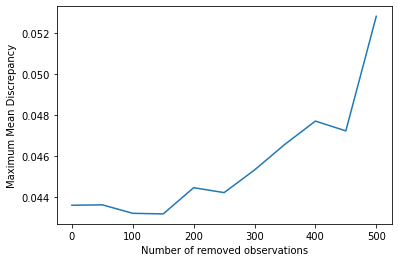

auc 0.6371925217703562


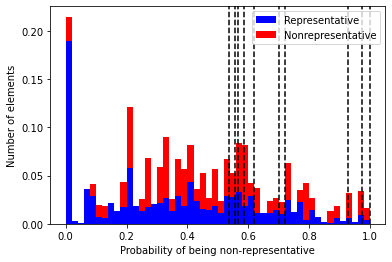

auc 0.5918131359851988
auc 0.5880815001803101
auc 0.596396005210595
auc 0.6011661211129296


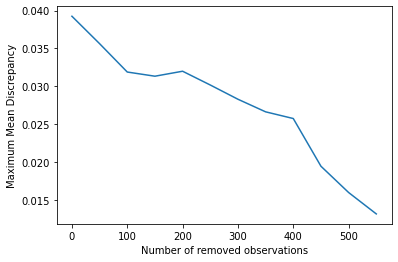

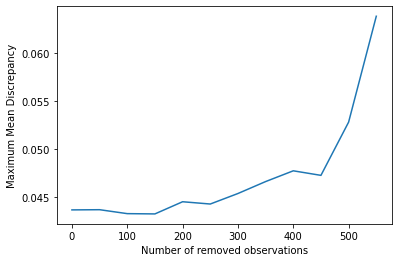

auc 0.46777940816825636


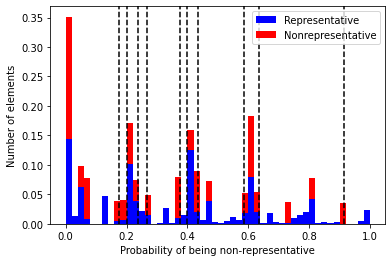

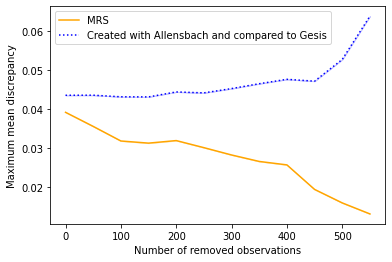

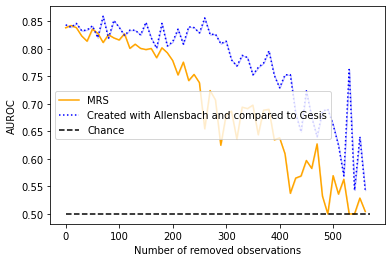

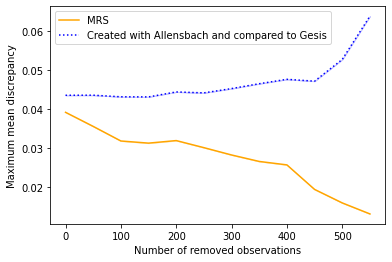

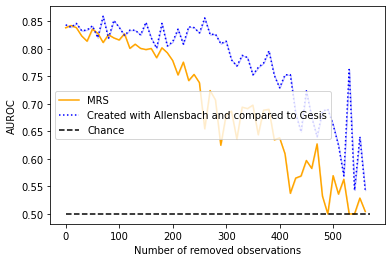

In [68]:
drop = 20
number_of_splits = 5
cv = 5
test_size = 0.3
mmd_iteration = 5
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) 
                           / drop) - 1

result_dir_allensbach = os.path.join(os.getcwd(), 'results/third_dataset_test/gbs_allensbach_gesis_check', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir_allensbach, exist_ok=True)

aucs = []
aucs_checking = []
mmds = []
mmds_checking = []

#calculate mrs with allensbach
for _ in tqdm(range(3)):
    auc, auc_checking, mmd, mmd_checking = repeated_MRS_with_third_dataset(scaled_allensbach_gbs, 
                      allensbach_columns+all_columns, comparing_dataset=scaled_gesis_checking, 
                      comparing_dataset_columns=gesis_columns+all_columns, 
                      number_of_iterations=number_of_iterations, 
                      number_of_splits=number_of_splits, n_drop=drop, test_size=test_size, cv=cv,
                                                                          directory=result_dir_allensbach)
    
    
    # allensbach
    aucs.append(auc)
    mmds.append(mmd)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)
    
    # gesis checking
    aucs_checking.append(auc_checking)
    mmds_checking.append(mmd_checking)
    median_mmds_checking = np.median(mmds_checking, axis = 0)
    std_mmds_checking = np.std(mmds_checking, axis = 0)
    median_aucs_checking = np.median(aucs_checking, axis = 0)
    std_aucs_checking = np.std(aucs_checking, axis = 0)
    
    plot_experiment_comparison_mmd(median_mmds, std_mmds,  median_mmds_checking, std_mmds_checking, 
                               "Created with Allensbach and compared to Gesis", drop, mmd_iteration, '', 
                                   save=False)
    plot_experiment_comparison_auc(median_aucs, std_aucs, median_aucs_checking, std_aucs_checking, 
                               "Created with Allensbach and compared to Gesis", drop, '',  save=False)
    
plot_experiment_comparison_mmd(median_mmds, std_mmds,  median_mmds_checking, std_mmds_checking, 
                               "Created with Allensbach and compared to Gesis", drop, mmd_iteration, 
                               result_dir_allensbach + "/mmds", save=True)
plot_experiment_comparison_auc(median_aucs, std_aucs, median_aucs_checking, std_aucs_checking, 
                               "Created with Allensbach and compared to Gesis", drop, 
                               result_dir_allensbach + "/aucs",  save=True)

### Save results

In [35]:
pickle.dump(median_aucs, open("results/allensbach_median_third_aucs", 'wb'))
pickle.dump(std_aucs, open("results/allenbach_std_third_aucs", 'wb'))
pickle.dump(median_mmds, open("results/allensbach_median_third_mmds", 'wb'))
pickle.dump(std_mmds, open("results/allenbach_std_third_mmds", 'wb'))

pickle.dump(median_aucs_checking, open("results/gesis_median_checking_aucs", 'wb'))
pickle.dump(std_aucs_checking, open("results/gesis_std_checking_aucs", 'wb'))
pickle.dump(median_mmds_checking, open("results/gesis_median_checking_mmds", 'wb'))
pickle.dump(std_mmds_checking, open("results/gesis_std_checking_mmds", 'wb'))

### Load  results

In [99]:
allensbach_median_comparison_aucs = pickle.load(open("results/allensbach_median_third_aucs", 'rb'))
allenbach_std_comparison_aucs = pickle.load(open("results/allenbach_std_third_aucs", 'rb'))
allensbach_median_third_mmds = pickle.load(open("results/allensbach_median_third_mmds", 'rb'))
allenbach_std_third_mmds = pickle.load(open("results/allenbach_std_third_mmds", 'rb'))

gesis_median_comparison_aucs = pickle.load(open("results/gesis_median_checking_aucs", 'rb'))
gesis_std_comparison_aucs = pickle.load(open("results/gesis_std_checking_aucs", 'rb'))
gesis_median_checking_mmds = pickle.load(open("results/gesis_median_checking_mmds", 'rb'))
gesis_std_checking_mmds = pickle.load(open("results/gesis_std_checking_mmds", 'rb'))

### Visualise results

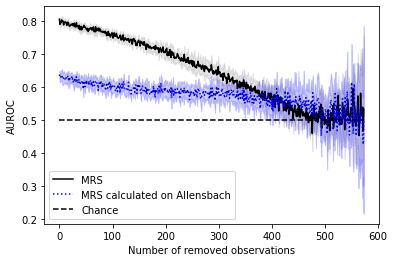

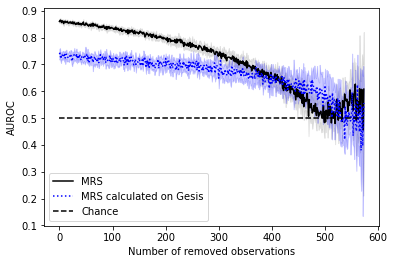

In [101]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/third_dataset/calculated_on_allensbach/")
os.makedirs(file_directory, exist_ok=True)

experiment_label = 'MRS calculated on Allensbach'

plot_experiment_comparison_mmd(allensbach_median_third_mmds, allenbach_std_third_mmds,  
                               gesis_median_checking_mmds, gesis_std_checking_mmds, 
                               "Created with Allensbach and compared to Gesis", drop, mmd_iteration, 
                               file_directory + "mmds", save=save)
plot_experiment_comparison_auc(allensbach_median_comparison_aucs, allenbach_std_comparison_aucs,
                               gesis_median_comparison_aucs, gesis_std_comparison_aucs, 
                               "Created with Allensbach and compared to Gesis", drop, 
                               file_directory + "aucs",  save=save)

### Create with gesis

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

auc 0.8902710421348761


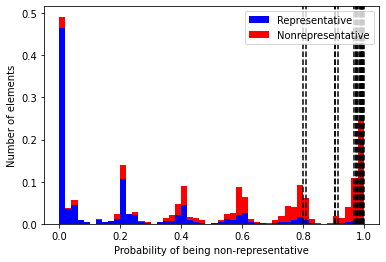

auc 0.8853085920248097
auc 0.8817549998668245
auc 0.8754187203063987
auc 0.8800717462224991


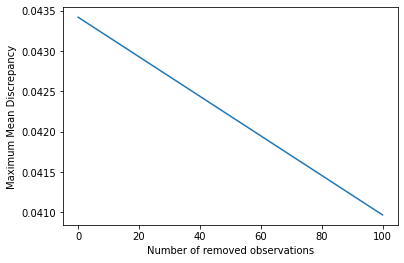

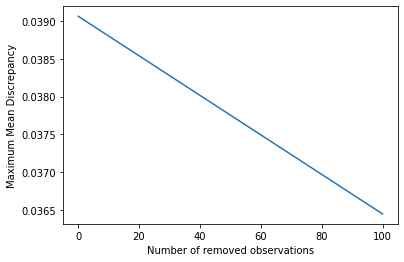

auc 0.8790718778973413


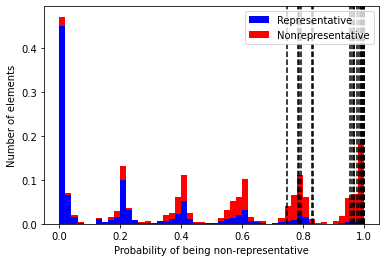

auc 0.8687136945204588
auc 0.8562363059028764
auc 0.8588037842401216
auc 0.8582674030333541


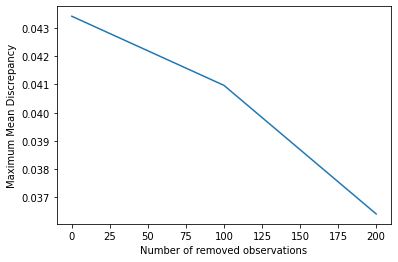

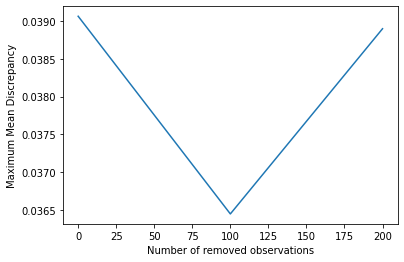

auc 0.8403051222358078


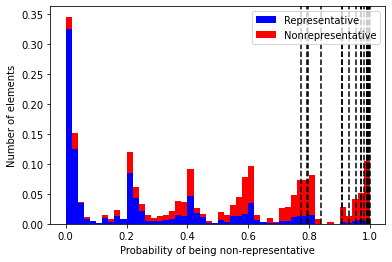

auc 0.8332093214133294
auc 0.8400772418427795
auc 0.8179863084140764
auc 0.8013937570201448


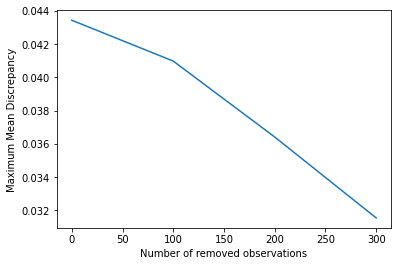

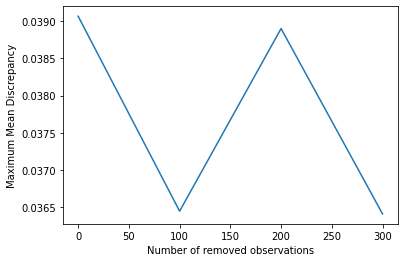

auc 0.8070526398368243


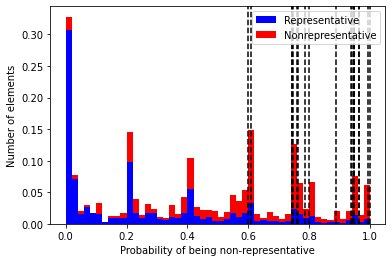

auc 0.7774806881655552
auc 0.8119119339918525
auc 0.7813930970596359
auc 0.7816145921416922


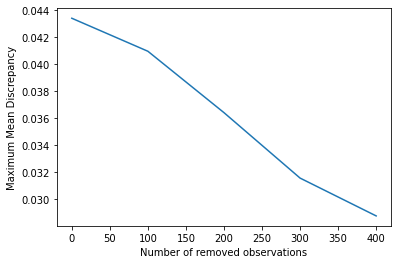

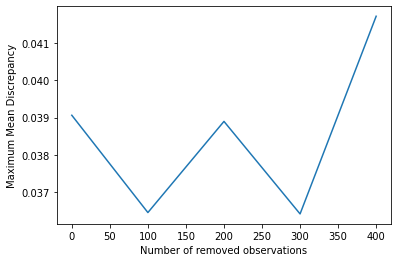

auc 0.7713034023122102


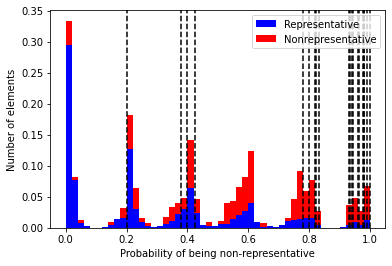

auc 0.7503511740091268
auc 0.6903096962298366
auc 0.7275048404864417
auc 0.6912654433247514


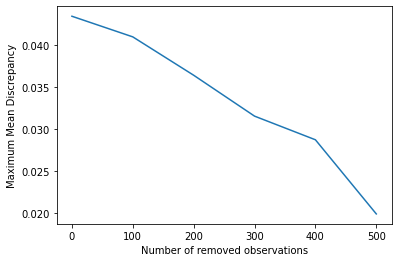

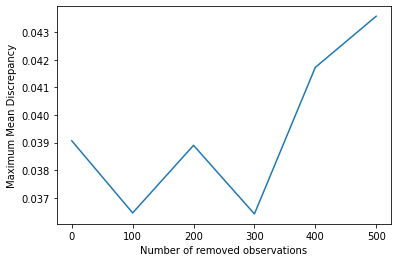

auc 0.6106723547759562


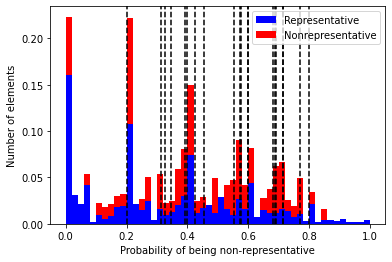

auc 0.5916167712442807


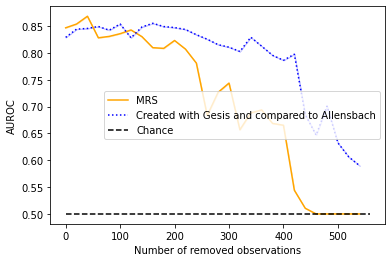

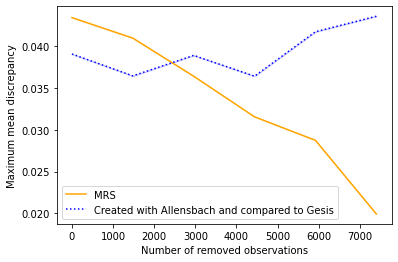

  0%|          | 0/27 [00:00<?, ?it/s]

auc 0.8966395018882833


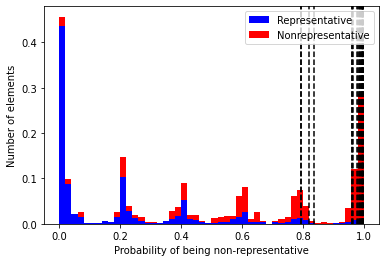

auc 0.8775403746477652
auc 0.8793938637095011
auc 0.8854090569196604
auc 0.876013264467273


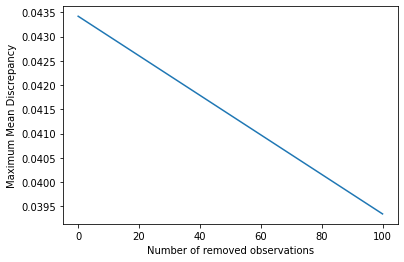

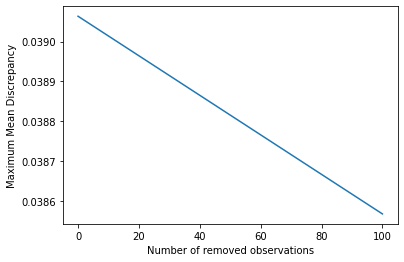

auc 0.8749080589267966


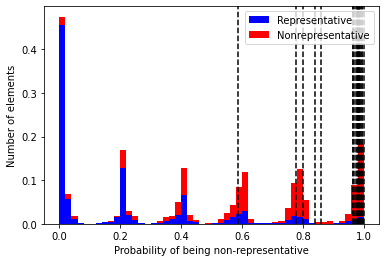

auc 0.8653916261727095
auc 0.8594033381028685
auc 0.8580525194472264
auc 0.8495520986509577


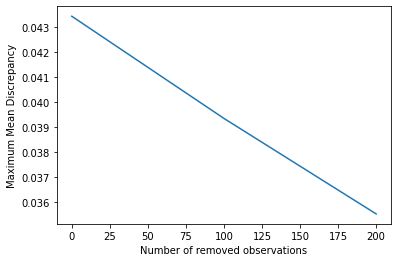

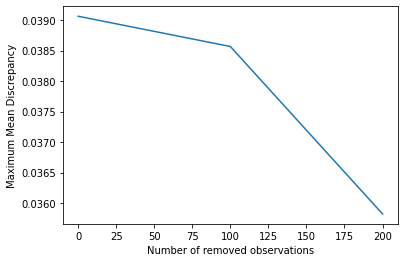

auc 0.851399460124406


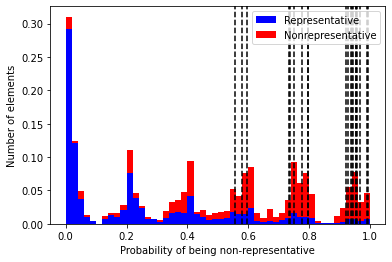

auc 0.8483080731432139
auc 0.8204123684142929
auc 0.8404300919781237
auc 0.8245933924252097


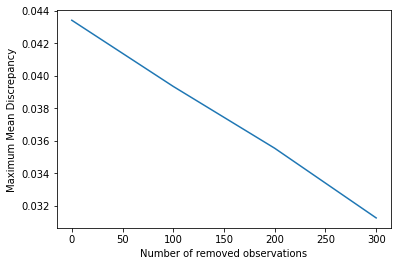

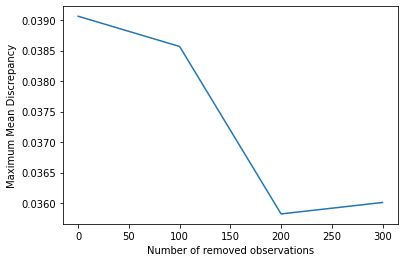

auc 0.8144842851491096


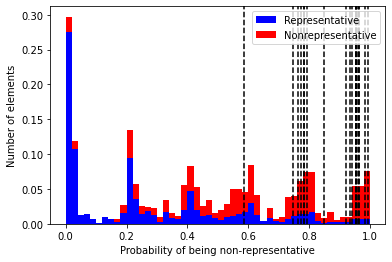

auc 0.8206073470841652
auc 0.7966132321560278
auc 0.7737990459210925
auc 0.7500014783259674


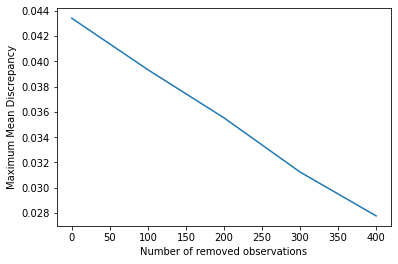

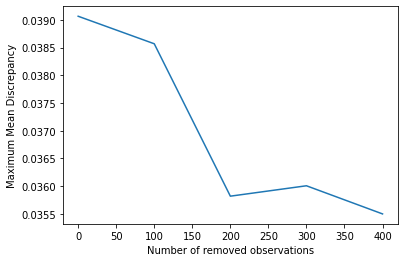

auc 0.7453945785469076


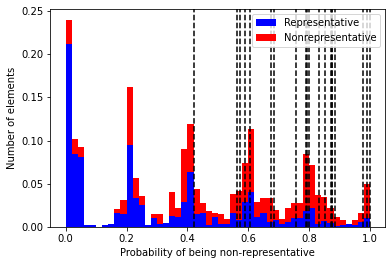

auc 0.73853559328055
auc 0.7379366452707449
auc 0.7052583801230542
auc 0.611786255114097


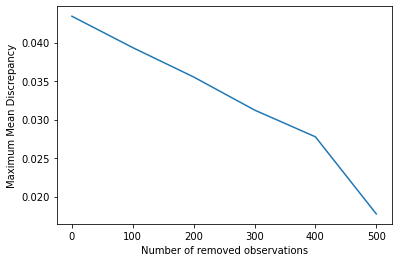

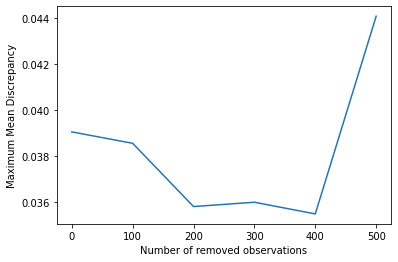

auc 0.6523977346866425


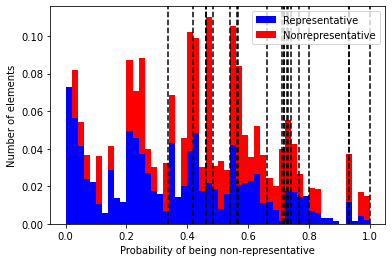

auc 0.5949714987773794


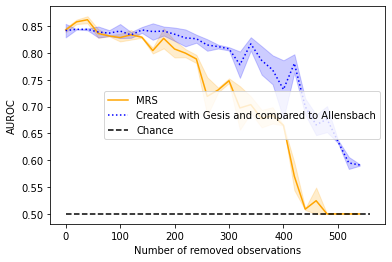

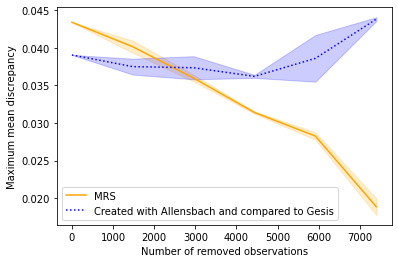

  0%|          | 0/27 [00:00<?, ?it/s]

auc 0.8841808150734237


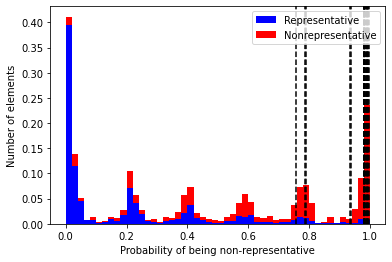

auc 0.8930812300989688
auc 0.8862794738126748
auc 0.8712327642773023
auc 0.8783603922365797


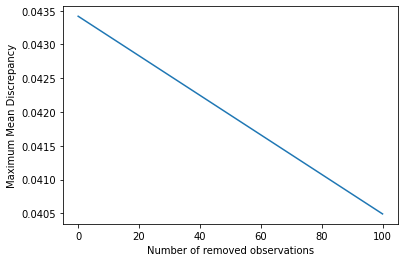

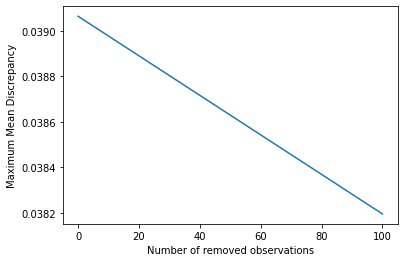

auc 0.8762132905151206


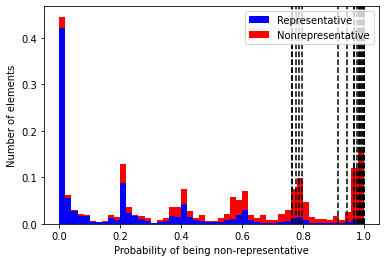

auc 0.8606679721128795
auc 0.8505672780571175
auc 0.852058128516551
auc 0.8525653389770023


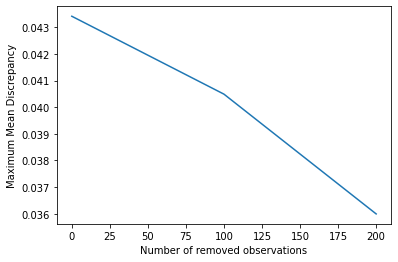

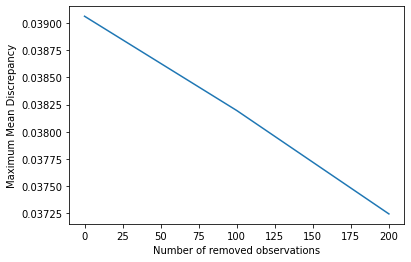

auc 0.8628965002474585


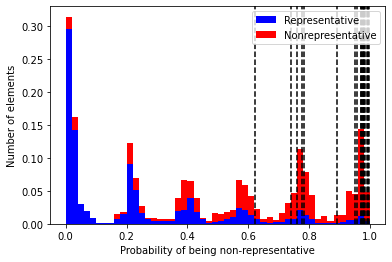

auc 0.8281988027987578
auc 0.8190613651242598
auc 0.8316520722928722
auc 0.8203905542205091


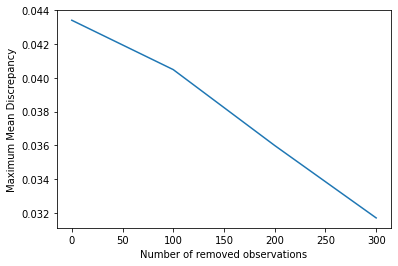

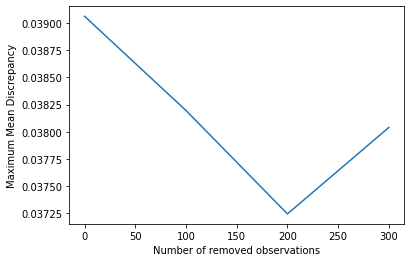

auc 0.8167627044440565


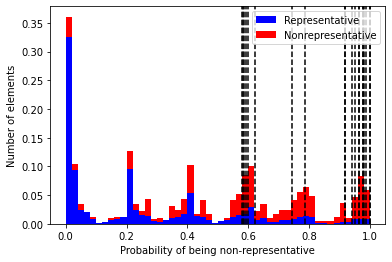

auc 0.794199589092505
auc 0.7820141780837431
auc 0.7639793838141876
auc 0.7833921312848072


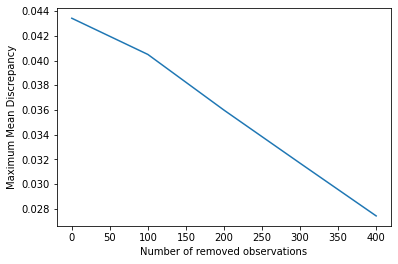

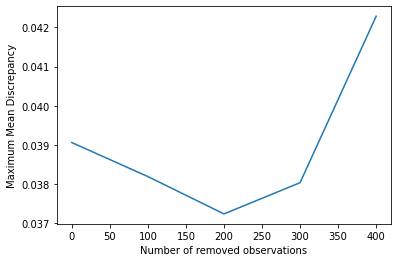

auc 0.7392965285292235


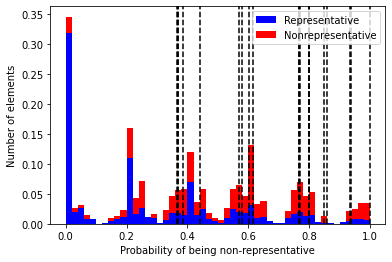

auc 0.7311043219936323
auc 0.745364546207233
auc 0.7405519044520609
auc 0.6829271771611145


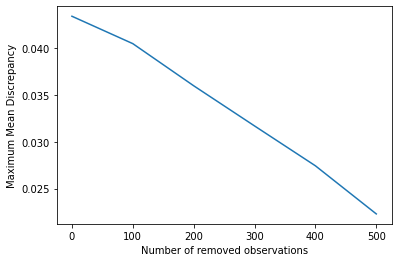

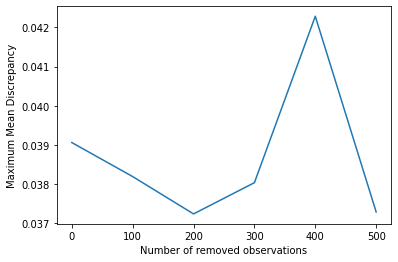

auc 0.6681989209672566


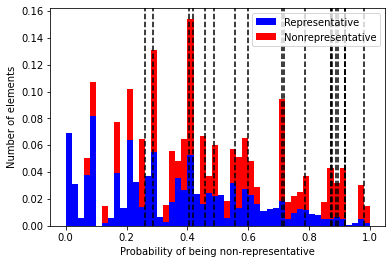

auc 0.6268015205970697


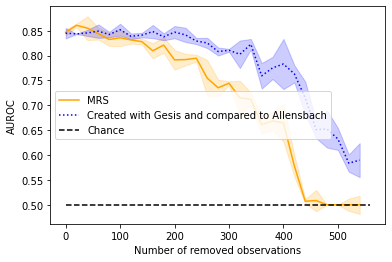

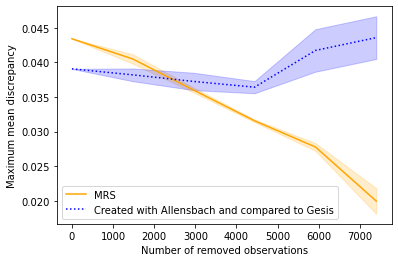

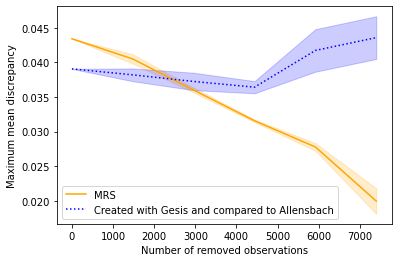

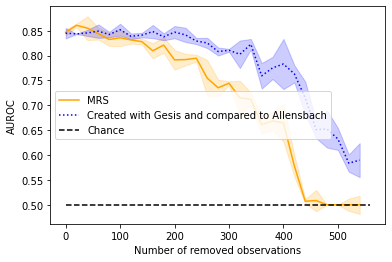

In [44]:
drop = 20
number_of_splits = 5
cv = 5
test_size = 0.3
mmd_iteration = 5
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) 
                           / drop) - 1
aucs = []
aucs_checking = []
mmds = []
mmds_checking = []

result_dir_gesis = os.path.join(os.getcwd(), 'results/third_dataset_test/gbs_gesis_allensbach_check', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir_gesis, exist_ok=True)

# calculate mrs with gesis
for temp in tqdm(range(3)):
    auc, auc_checking, mmd, mmd_checking = repeated_MRS_with_third_dataset(scaled_gesis_gbs, 
                      gesis_columns + all_columns, scaled_allensbach_checking, 
                        allensbach_columns+all_columns, 
                      number_of_iterations=number_of_iterations, 
                      number_of_splits=number_of_splits, n_drop=drop, test_size=test_size, cv=cv,
                                                                          directory=result_dir_gesis)
    
    # allensbach
    mmds.append(mmd)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    aucs.append(auc)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)
    
    # gesis checking
    mmds_checking.append(mmd_checking)
    median_mmds_checking = np.median(mmds_checking, axis = 0)
    std_mmds_checking = np.std(mmds_checking, axis = 0)
    aucs_checking.append(auc_checking)
    median_aucs_checking = np.median(aucs_checking, axis = 0)
    std_aucs_checking = np.std(aucs_checking, axis = 0)
    
    plot_experiment_comparison_auc(median_aucs, std_aucs, median_aucs_checking, std_aucs_checking, 
                               "Created with Gesis and compared to Allensbach", drop, '',  save=False)
    plot_experiment_comparison_mmd(median_mmds, std_mmds,  median_mmds_checking, std_mmds_checking, 
                               "Created with Allensbach and compared to Gesis", drop, mrs_iteration, '', 
                                   save=False)
    
plot_experiment_comparison_mmd(median_mmds, std_mmds,  median_mmds_checking, std_mmds_checking, 
                               "Created with Gesis and compared to Allensbach", drop, mrs_iteration, 
                               result_dir_gesis + "/mmds", save=True)
plot_experiment_comparison_auc(median_aucs, std_aucs, median_aucs_checking, std_aucs_checking, 
                               "Created with Gesis and compared to Allensbach", drop, 
                               result_dir_gesis + "/aucs",  save=True)

### Save results

In [35]:
pickle.dump(median_aucs, open("results/gesis_median_third_aucs", 'wb'))
pickle.dump(std_aucs, open("results/gesis_std_third_aucs", 'wb'))
pickle.dump(median_mmds, open("results/gesis_median_third_mmds", 'wb'))
pickle.dump(std_mmds, open("results/gesis_std_third_mmds", 'wb'))

pickle.dump(median_aucs_checking, open("results/allensbach_median_checking_aucs", 'wb'))
pickle.dump(std_aucs_checking, open("results/allensbach_std_checking_aucs", 'wb'))
pickle.dump(median_mmds_checking, open("results/allensbach_median_checking_mmds", 'wb'))
pickle.dump(std_mmds_checking, open("results/allensbach_std_checking_mmds", 'wb'))

### Load  results

In [99]:
gesis_median_comparison_aucs = pickle.load(open("results/gesis_median_third_aucs", 'rb'))
gesis_std_comparison_aucs = pickle.load(open("results/gesis_std_third_aucs", 'rb'))
gesis_median_third_mmds = pickle.load(open("results/gesis_median_third_mmds", 'rb'))
gesis_std_third_mmds = pickle.load(open("results/gesis_std_third_mmds", 'rb'))

allensbach_median_comparison_aucs = pickle.load(open("results/allensbach_median_checking_aucs", 'rb'))
allensbach_std_comparison_aucs = pickle.load(open("results/allensbach_std_checking_aucs", 'rb'))
allensbach_median_checking_mmds = pickle.load(open("results/allensbach_median_checking_mmds", 'rb'))
allensbach_std_checking_mmds = pickle.load(open("results/allensbach_std_checking_mmds", 'rb'))

### Visualise results

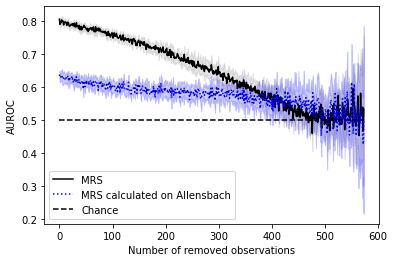

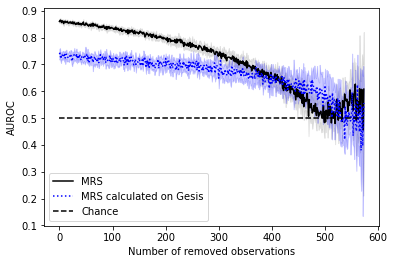

In [101]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/third_dataset/calculated_on_gesis/")
os.makedirs(file_directory, exist_ok=True)

experiment_label = 'MRS calculated on Gesis'

plot_experiment_comparison_mmd(gesis_median_third_mmds, gesis_std_third_mmds,  
                               allensbach_median_checking_mmds, allensbach_std_checking_mmds, 
                               "Created with Allensbach and compared to Gesis", drop, mmd_iteration, 
                               file_directory + "mmds", save=save)
plot_experiment_comparison_auc(gesis_median_comparison_aucs, gesis_std_comparison_aucs,
                               allensbach_median_comparison_aucs, allensbach_std_comparison_aucs, 
                               "Created with Gesis and compared to Gesis", drop, 
                               file_directory + "aucs",  save=save)

# Compare MRS with temperature sampling and without 

### Run experiment

  0%|          | 0/3 [00:00<?, ?it/s]

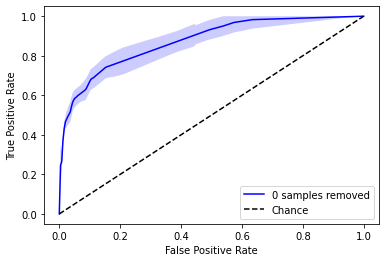

  0%|          | 0/27 [00:00<?, ?it/s]

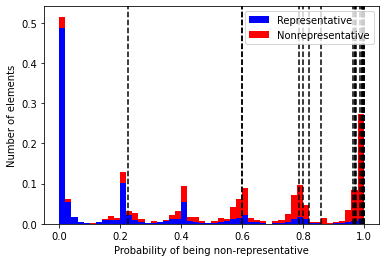

graph auc: 0.8485916630285006
graph auc: 0.8553114924724566
graph auc: 0.8423253737221673
graph auc: 0.8356819527219818
graph auc: 0.8544794025570057


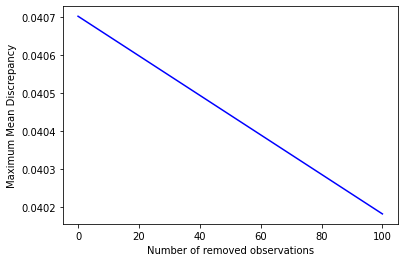

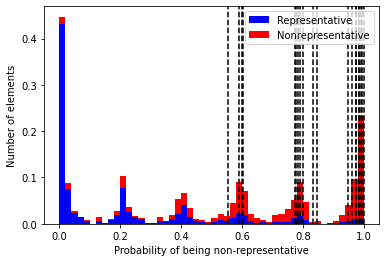

graph auc: 0.8552104016287727
graph auc: 0.8297233469015952
graph auc: 0.8270359944991238


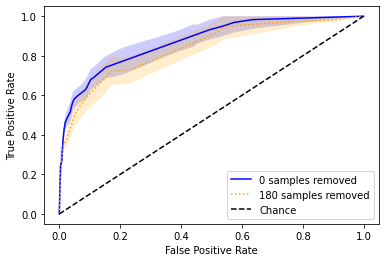

graph auc: 0.8371994635623181
graph auc: 0.854456205479402


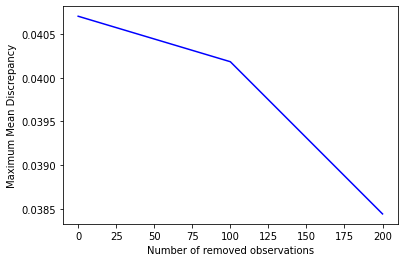

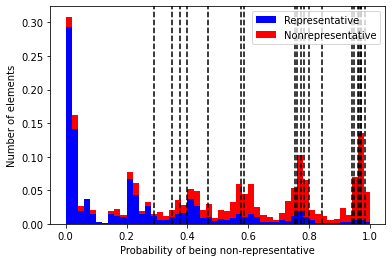

graph auc: 0.8069174951399738
graph auc: 0.8184103806654187
graph auc: 0.8253288257440786
graph auc: 0.7903105529504927
graph auc: 0.7561466663247375


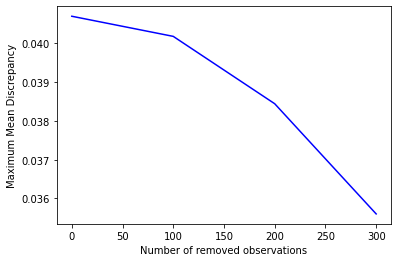

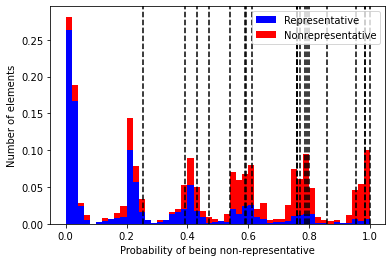

graph auc: 0.6975110766145832
graph auc: 0.7121010606357672


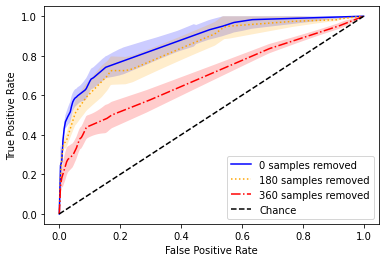

graph auc: 0.70746323223632
graph auc: 0.6641952030336462
graph auc: 0.6474268649116498


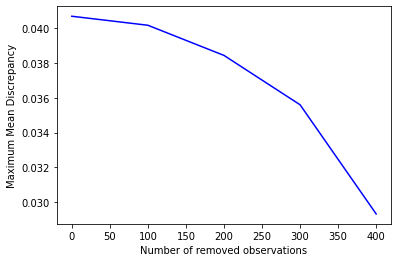

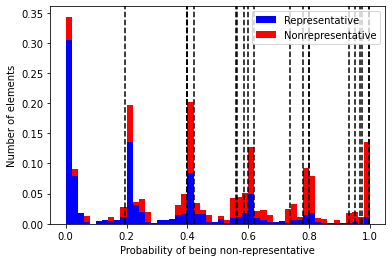

graph auc: 0.6046247628083491
graph auc: 0.5536128251064855
graph auc: 0.5567843137254902
graph auc: 0.5727120743034055
graph auc: 0.5226509803921568


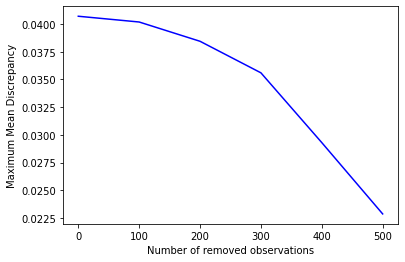

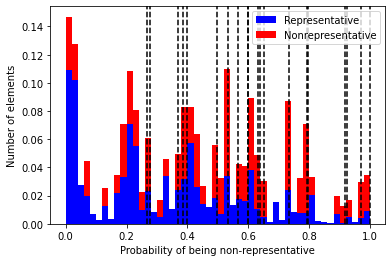

graph auc: 0.5


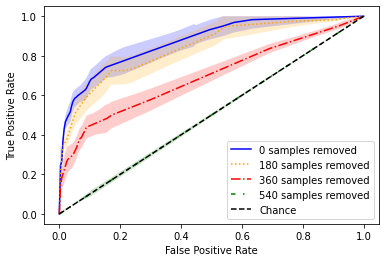

graph auc: 0.5034453781512604


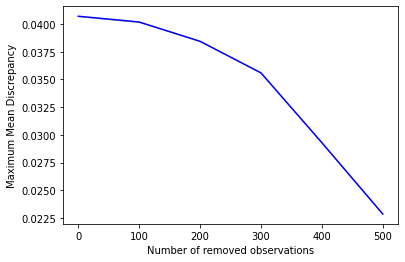

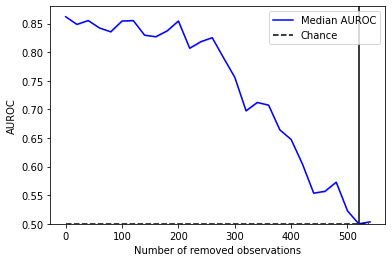

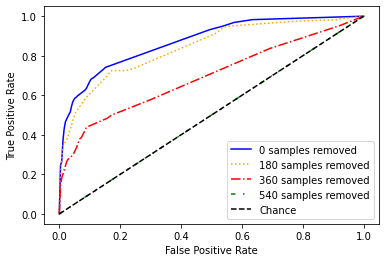

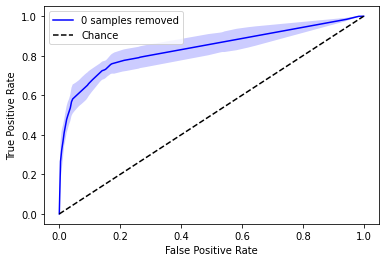

  0%|          | 0/27 [00:00<?, ?it/s]

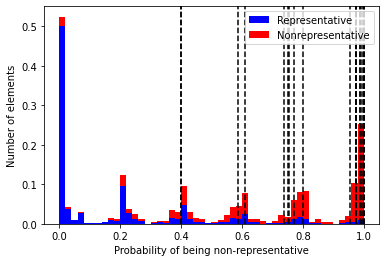

graph auc: 0.821551625344054
graph auc: 0.8601138853076906
graph auc: 0.8210063682529463
graph auc: 0.8232388368406575
graph auc: 0.8353993004426989


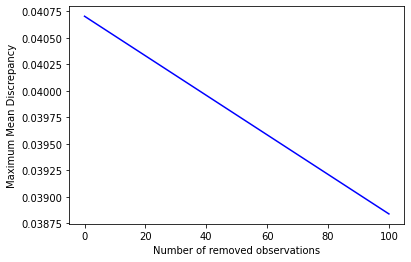

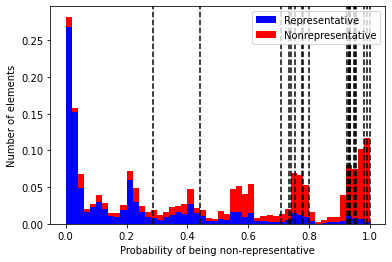

graph auc: 0.8192504320588512
graph auc: 0.8139475399462265
graph auc: 0.7781770486047883


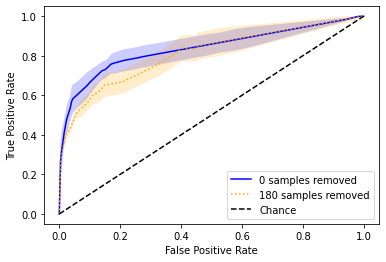

graph auc: 0.8117825629030518
graph auc: 0.8361919386493671


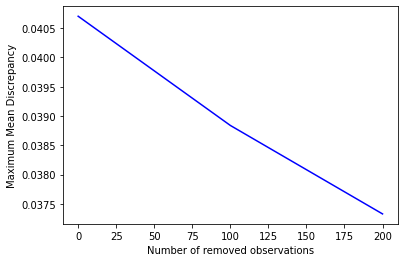

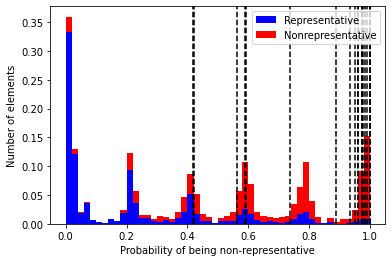

graph auc: 0.7982038836675256
graph auc: 0.7723964559804568
graph auc: 0.7577205947308252
graph auc: 0.7600893931084641
graph auc: 0.7387204800776719


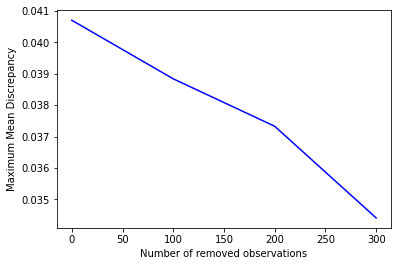

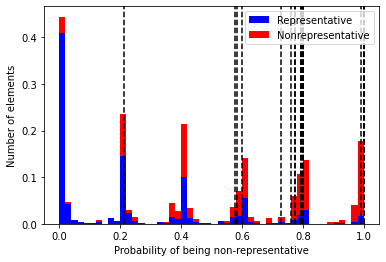

graph auc: 0.7348820366097929
graph auc: 0.7091482797991011


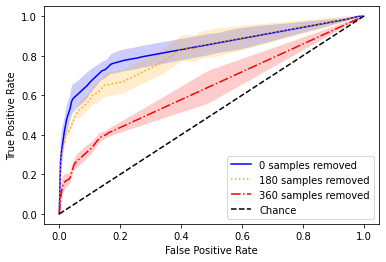

graph auc: 0.6644656264002698
graph auc: 0.644664870302565
graph auc: 0.7013311443462348


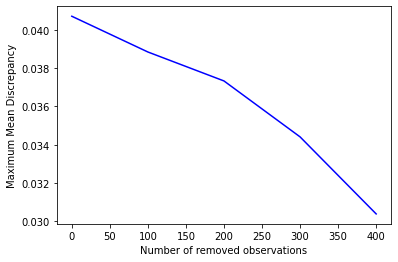

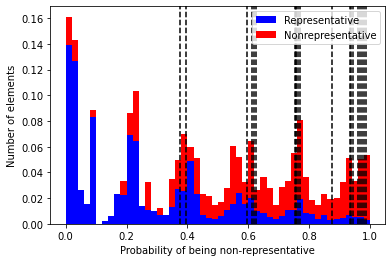

graph auc: 0.6470779174573056
graph auc: 0.5171008403361345
graph auc: 0.5614232407717017
graph auc: 0.520565371024735
graph auc: 0.5271720588235295


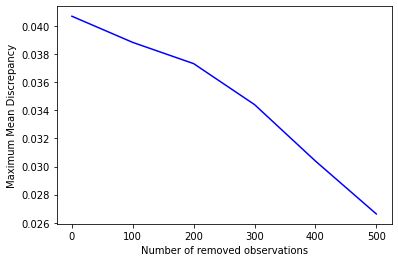

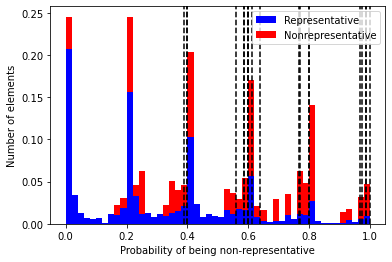

graph auc: 0.4967020023557126


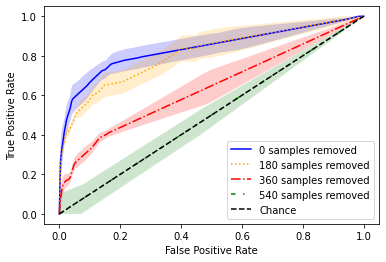

graph auc: 0.5223797200859142


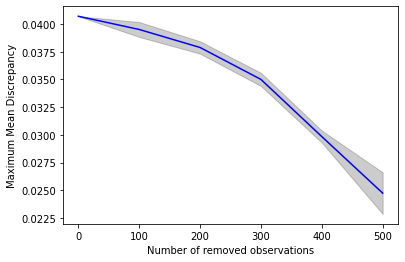

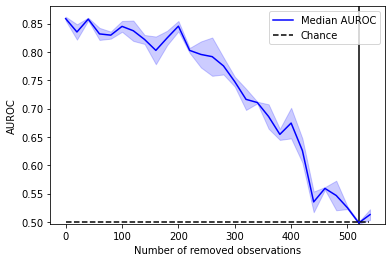

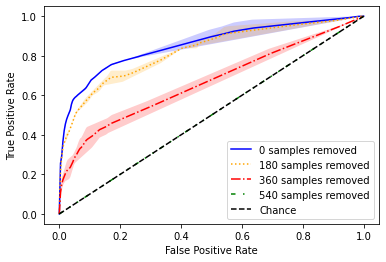

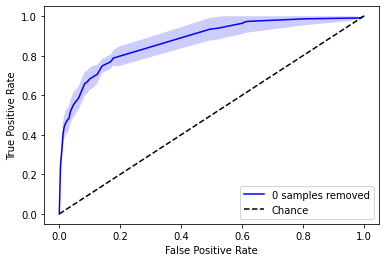

  0%|          | 0/27 [00:00<?, ?it/s]

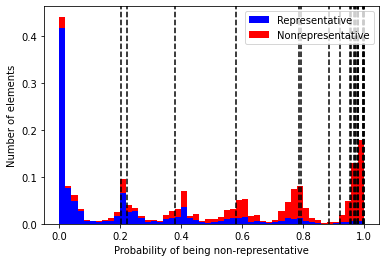

graph auc: 0.842773246510905
graph auc: 0.8406697547232307
graph auc: 0.8367215066584353
graph auc: 0.8404300616642416
graph auc: 0.8135824510502856


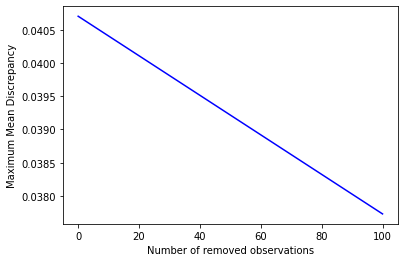

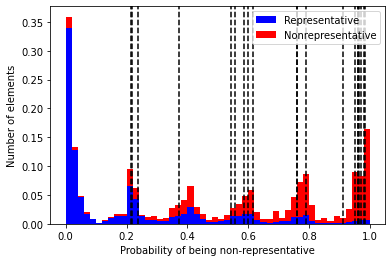

graph auc: 0.8447054013919167
graph auc: 0.8219890812090979
graph auc: 0.8519560862447921


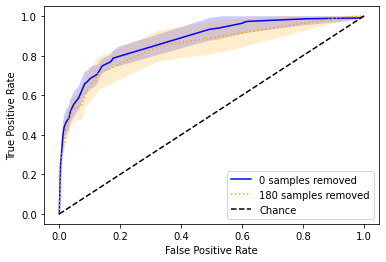

graph auc: 0.8277061310797074
graph auc: 0.8436864201555647


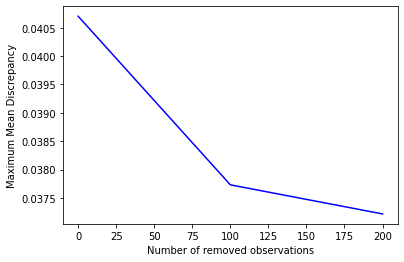

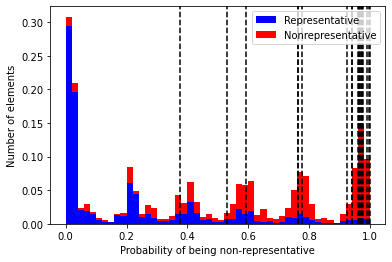

graph auc: 0.7948942489049016
graph auc: 0.815468281856031
graph auc: 0.8338391374512113
graph auc: 0.8081786344539212
graph auc: 0.7995053292373807


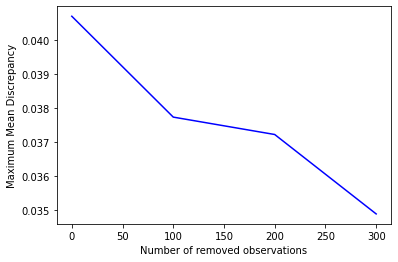

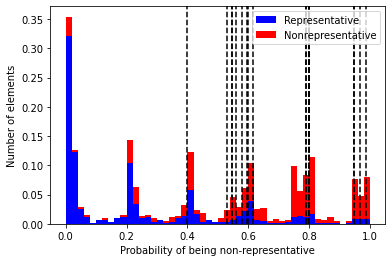

graph auc: 0.742119839746333
graph auc: 0.7454188838079402


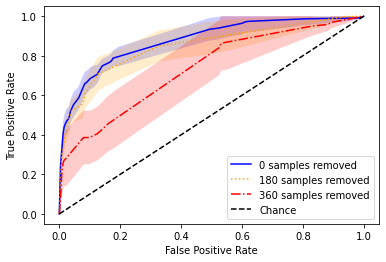

graph auc: 0.6920028603407536
graph auc: 0.7123483771165438
graph auc: 0.6909565455707214


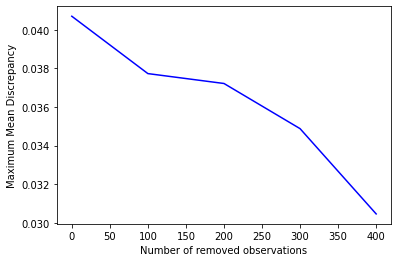

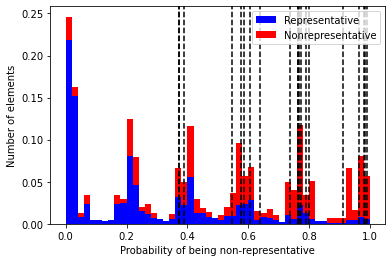

graph auc: 0.6348768462674025
graph auc: 0.5240714285714285
graph auc: 0.6694304771071126
graph auc: 0.5207678018575852
graph auc: 0.5018235294117648


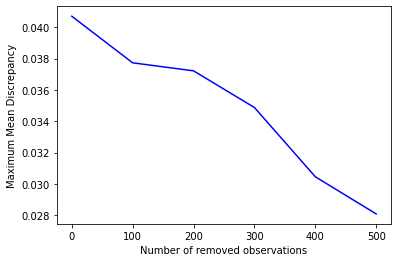

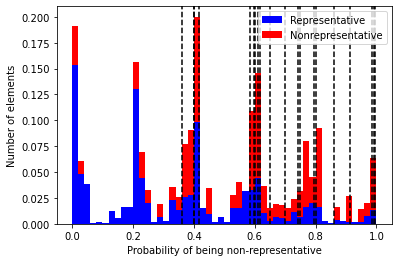

graph auc: 0.5380784313725491


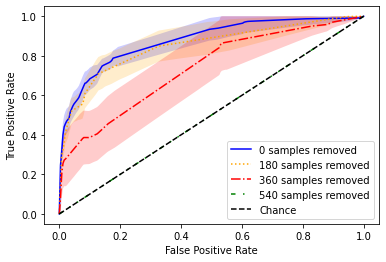

graph auc: 0.5


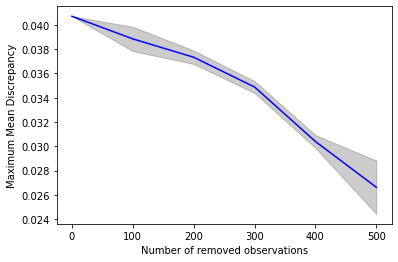

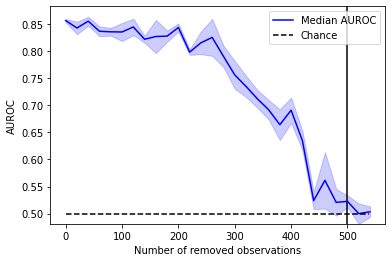

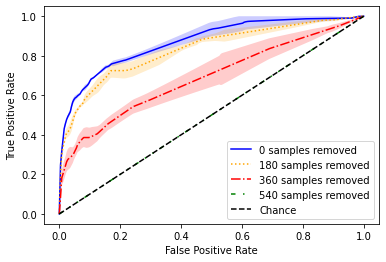

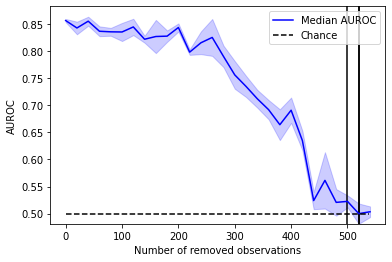

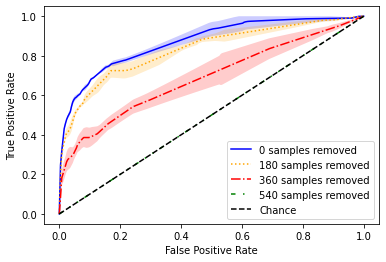

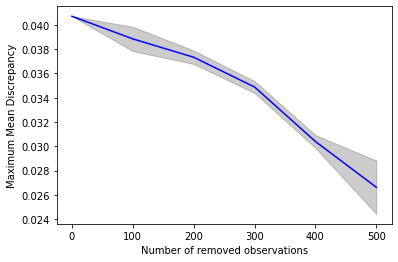

In [43]:
drop = 20
number_of_splits = 5
result_dir_temperature = os.path.join(os.getcwd(), 'results/temperature_comparison',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

cv= 5
test_size = 0.3
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) 
                           / drop) - 1
os.makedirs(result_dir_temperature, exist_ok=True)
aucs_without_temperature = []
rocs_without_temperature = []
mmds_without_temperature = []
mrs_iterations = []
mmd_iteration = 5
    
for _ in tqdm(range(3)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_gesis_gbs, gesis_columns,
                     number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=cv, directory=result_dir_temperature,
                                                 number_of_iterations=number_of_iterations, temperature_sampling=False)
    
    aucs_without_temperature.append(auc)
    rocs_without_temperature.append(roc)
    mmds_without_temperature.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs_without_temperature)
    median_mmds = np.median(mmds_without_temperature, axis = 0)
    std_mmds = np.std(mmds_without_temperature, axis = 0)
    median_aucs = np.median(aucs_without_temperature, axis = 0)
    std_aucs = np.std(aucs_without_temperature, axis = 0)
    
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=False)
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iteration)
    plot_rocs(median_rocs, '', save=False)
    
plot_auc_median(median_aucs, std_aucs, drop, result_dir_temperature + "/median_aucs" , 
                save=True, mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_temperature + "/median_rocs", save=True)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_temperature + "/median_mmds", save=True)


pickle.dump(median_aucs, open(result_dir_temperature + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_temperature + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_temperature + "/median_rocs", 'wb'))
pickle.dump(median_mmds, open(result_dir_temperature + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_temperature + "/std_mmds", 'wb'))

### Save results

In [44]:
pickle.dump(median_aucs, open("results/median_aucs_without_temperature", 'wb'))
pickle.dump(std_aucs, open("results/std_aucs_without_temperature", 'wb'))
pickle.dump(median_rocs, open("results/median_rocs_without_temperature", 'wb'))
pickle.dump(median_mmds, open("results/median_mmds_without_temperature", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_temperature", 'wb'))
pickle.dump(mrs_iterations, open("results/mrs_iterations_without_temperature", 'wb'))

### Load saved results

In [48]:
median_aucs_without_temperature = pickle.load(open("results/median_aucs_without_temperature", 'rb'))
std_aucs_without_temperature = pickle.load(open("results/std_aucs_without_temperature", 'rb'))
median_aucs_temperature = pickle.load(open("results/gesis_median_aucs", 'rb'))
std_aucs_temperature = pickle.load(open("results/gesis_std_aucs", 'rb'))

median_mmds_without_temperature = pickle.load(open("results/median_mmds_without_temperature", 'rb'))
std_mmds_without_temperature = pickle.load(open("results/std_mmds_without_temperature", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))

mrs_iterations_without_temperature = pickle.load(open("results/mrs_iterations_without_temperature", 'rb'))

### Visualise results

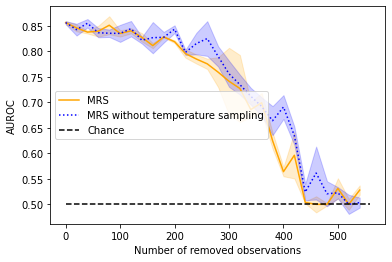

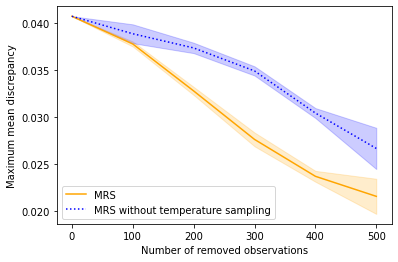

In [50]:
experiment_label = 'MRS without temperature sampling'   
file_directory = 'final/temperature_comparison/'
save = False
plot_experiment_comparison_auc(median_aucs_temperature, std_aucs_temperature, median_aucs_without_temperature, 
                                std_aucs_without_temperature, experiment_label, 
                           drop, file_directory + 'aucs', save=save)   
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_without_temperature, 
                               std_mmds_without_temperature, 
                               experiment_label, drop, mmd_iteration, 
                               file_directory + 'mmds',  save=save)

# Compare MRS with cross-validation and without

In [ ]:
def MRS_without_cv(N: pd.DataFrame, R: pd.DataFrame, columns: list, number_of_splits = 5,
        n_drop: int=1, cv=5):
    
    preds = []
    bootstrap_iterations = 20
    kf = KFold(n_splits=number_of_splits)
    bootstrap_predictions = np.zeros(len(N))
    counter = np.zeros(len(N))
    n = min(len(R), len(N))
    for _ in range(bootstrap_iterations):
        n_sample = N.sample(n=n, replace=True)
        N_test = N.drop(n_sample.index)
        
        while len(N_test) == 1:
            n_sample = N.sample(n=n, replace=True)
            N_test = N.drop(n_sample.index)
        
        bootstrap = pd.concat([n_sample,
                                  R.sample(n=n, replace=True)])
        
        locations_not_in_bootstrap = list(set([N.index.get_loc(index) for index in N_test.index]))
        clf = grid_search(bootstrap[columns], bootstrap.label, 5)
        clf.fit(bootstrap[columns], bootstrap.label)
        proba = clf.predict_proba(N_test[columns])[:,1]
        bootstrap_single = np.zeros(len(N))
        bootstrap_single[list(locations_not_in_bootstrap)] = proba
        counter[list(locations_not_in_bootstrap)] += 1
        bootstrap_predictions += bootstrap_single
    with np.errstate(divide='ignore'):
        preds = bootstrap_predictions / counter
    preds = [0 if x != x else x for x in preds]
    drop_ids = temperature_sample(preds, 1, n_drop)
    return N.drop(N.index[drop_ids])

def repeated_MRS_without_cv(df, columns, number_of_splits, n_drop=1,test_size=0.33, cv=5, us=False, directory='', 
                 compas_bias='', temperature_sampling=True, number_of_iterations=None):
    
    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    if number_of_iterations is None:
        number_of_iterations = int(len(N) / drop)
    aucs = []
    rocs = []
    ratio = []
    mmds = []
    kl_values = []
    mmd_iteration = 5
    
    auroc_iteration = int(int(len(N) / n_drop) / 3.5) + 1
    
    if us:
        representative_ratio = (len(R[R[compas_bias] == 1]) /
                                len(R[R[compas_bias] == 0]))
        ratio.extend([len(N[N[compas_bias] == 1]) / 
                         (len(N[N[compas_bias] == 0]))]*drop)
        
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    rocs.append(roc)
    plot_rocs(rocs, '', save=False)
    mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.005
    mrs = N
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS_without_cv(N, R, columns,
                                number_of_splits=number_of_splits,
                                n_drop=n_drop, cv=cv)
        
        
        
        if((i+1) % auroc_iteration == 0):
            auc, roc = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=True)
            aucs.append(auc)
            rocs.append(roc)
            plot_rocs(rocs, '', save=False)
        else:
            auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
            aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = i + 1
            mrs = N.copy(deep=True)
            
        print(f'graph auc: {auc}')
        
        if ((i+1) % mmd_iteration == 0):
            mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
            plot_mmds(mmds, drop, mmd_iteration, '', False)
            
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    
    
    return aucs, rocs, mrs, mmds, mrs_iteration * n_drop

In [ ]:
drop = 20
number_of_splits = 5
result_dir_cv = os.path.join(os.getcwd(), 'results/cv__comparison',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.5
number_of_iterations = int((len(scaled_gesis_gbs[scaled_gesis_gbs['label']  == 1]) -
                           number_of_splits)/drop)

os.makedirs(result_dir_cv, exist_ok=True)
cv = 5
aucs_without_cv = [] 
aucs_without_cv = []
rocs_without_cv = []
mmds_without_cv = []
mrs_iterations = []
mmd_iteration = 5
    
for temp in tqdm(range(3)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS_without_cv(scaled_gesis_gbs, gesis_columns, 
                    number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=cv, number_of_iterations=number_of_iterations)
    
    aucs_without_cv.append(auc)
    rocs_without_cv.append(roc)
    mmds_without_cv.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs_without_cv)
    median_mmds = np.median(mmds_without_cv, axis = 0)
    std_mmds = np.std(mmds_without_cv, axis = 0)
    median_aucs = np.median(aucs_without_cv, axis = 0)
    std_aucs = np.std(aucs_without_cv, axis = 0)
    
    plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, '', save=False)
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False, mrs_iteration=mrs_iteration)
    plot_rocs(median_rocs, '', save=False)


plot_auc_median(median_aucs, std_aucs, drop, result_dir_cv + "/median_aucs" , 
                save=True, mrs_iteration=mrs_iterations)
plot_rocs(median_rocs, result_dir_cv + "/median_rocs", save=True)
plot_mmds_median(median_mmds, std_mmds, drop, mmd_iteration, result_dir_cv + "/median_mmds", save=True)


pickle.dump(median_aucs, open(result_dir_cv + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_cv + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_cv + "/median_rocs", 'wb'))
pickle.dump(median_mmds, open(result_dir_cv + "/median_mmds", 'wb'))
pickle.dump(std_mmds, open(result_dir_cv + "/std_mmds", 'wb'))

### Save results

In [ ]:
pickle.dump(median_aucs_without_cv, open("results/median_aucs_without_cv", 'wb'))
pickle.dump(std_aucs_without_cv, open("results/std_aucs_without_cv", 'wb'))
pickle.dump(median_mmds_without_cv, open("results/median_mmds_without_cv", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_cv", 'wb'))

pickle.dump(median_rocs, open("results/median_rocs_without_cv", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_cv", 'wb'))
pickle.dump(mrs_iterations, open("results/mrs_iterations_without_cv", 'wb'))

### Load results

In [45]:
gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
median_aucs_without_cv = pickle.load(open("results/median_aucs_without_cv", 'rb'))
std_aucs_without_cv = pickle.load(open("results/std_aucs_without_cv", 'rb'))

median_mmds_without_cv = pickle.load(open("results/median_mmds_without_cv", 'rb'))
std_mmds_without_cv = pickle.load(open("results/std_mmds_without_cv", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))

mrs_iterations_without_temperature = pickle.load(open("results/mrs_iterations_without_cv", 'rb'))

### Visualise results

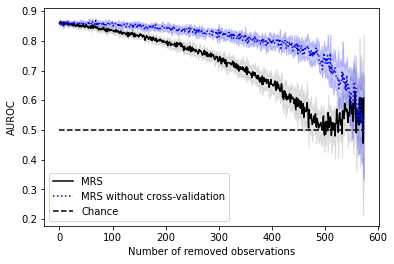

In [95]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/cross_validation_comparison/")
os.makedirs(file_directory, exist_ok=True)

experiment_label = 'MRS without cross-validation'


 
plot_experiment_comparison_auc(gesis_median_aucs, gesis_std_aucs, median_aucs_without_cv, 
                                std_aucs_without_cv, experiment_label, drop, 
                           file_directory+'auc', save=save)    
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_without_cv, 
                               std_mmds_without_cv, 
                               experiment_label, drop, mmd_iteration, file_directory+'mmd',  save=save)

# Random drops

### Run experiment

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

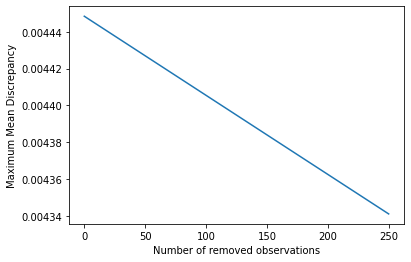

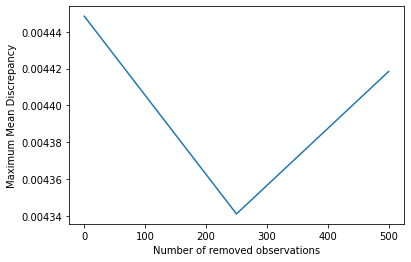

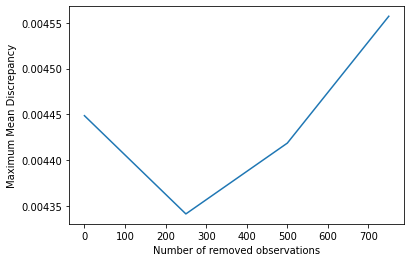

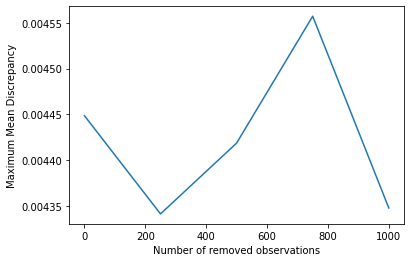

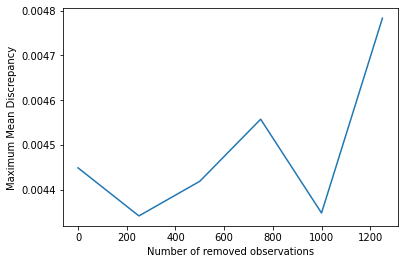

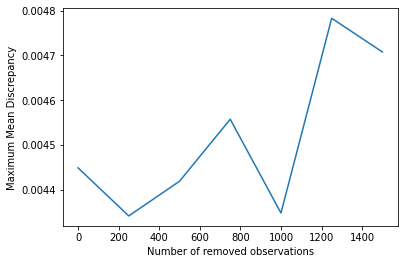

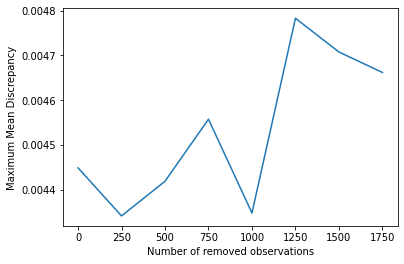

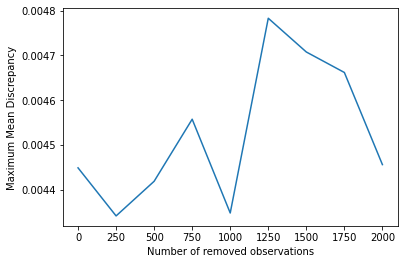

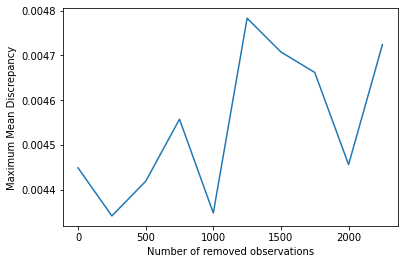

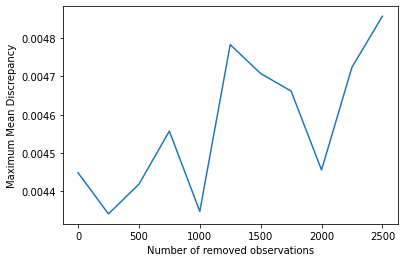

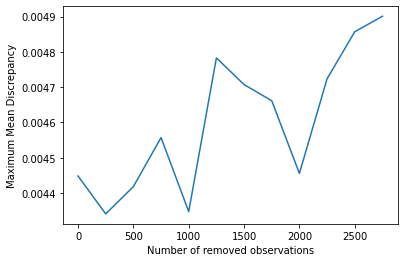

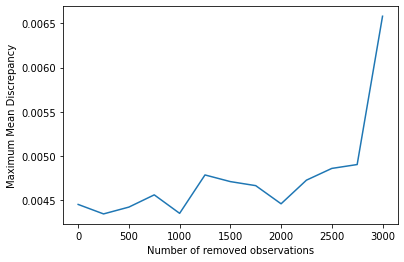

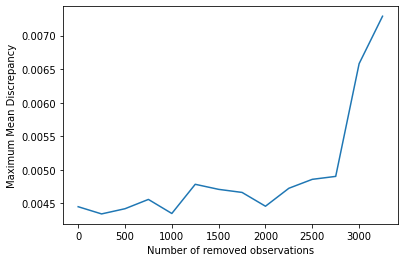

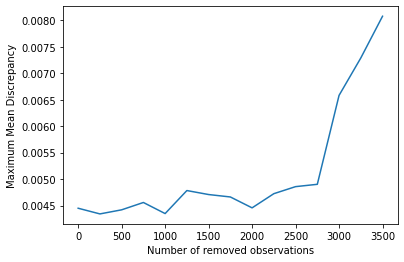

/home/tony/.virtualenvs/mrs/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: plot_auc_median() got an unexpected keyword argument 'mmd_iteration'

In [22]:
drop = 50
result_dir = os.path.join(os.getcwd(), 'results/random_drop',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
cv = 5
test_size = 0.3
number_of_splits = 5
aucs_random_drop = []
mmds = []
mmd_iteration = 5
os.makedirs(result_dir, exist_ok=True)

#compas_nonrep_more_young
#compas_nonrep_more_old 
#compas_rep
#data = scaled_gesis_gbs
# columns = gesis_columns
data = compas_nonrep_more_young
columns = compas_columns
mrs_iterations = []

for _ in tqdm(range(3)):
    
    N = data[data['label'] == 1].copy()
    R = data[data['label'] == 0].copy()
    iterations = int(len(N)/drop) - cv - 1
    aucs = [] 
    mmd = []
    
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.005
    mrs = N
    
    for i in tqdm(range(iterations)):
        
        random_int = random.sample(range(0, len(N)), drop)
        N.drop(N.index[random_int], inplace=True)
    
        auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
        aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = i + 1
            mrs = N.copy(deep=True)
            
        if ((i+1) % mmd_iteration == 0):
            mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
            plot_mmds(mmds, drop, mmd_iteration, '', False)
        
    mrs_iterations.append(mrs_iteration)
    aucs_random_drop.append(aucs)
    mmds.append(mmd)
    median_aucs_random_drop = np.median(aucs_random_drop, axis = 0)
    median_mmd_random_drop = np.median(mmds, axis = 0)
    std_aucs_random_drop = np.std(aucs_random_drop, axis = 0)
    std_mmds_random_drop = np.std(mmds, axis = 0)
    plot_auc_median(median_aucs_random_drop, std_aucs_random_drop, drop, '', save=False, 
                   mmd_iteration=mrs_iteration)
    plot_mmds_median(median_mmd_random_drop, std_mmds_random_drop, drop, '', save=False)
    
   
    
plot_auc_median(median_aucs_random_drop, std_aucs_random_drop, drop, 
                result_dir + '/random_drop_experiment_auc', save=True, mrs_iteration=mrs_iteration)
plot_mmds_median(median_mmd_random_drop, std_mmds_random_drop, drop, 
               result_dir + '/random_drop_experiment_mmd', save=True)

pickle.dump(median_aucs_random_drop, open(result_dir + "/median_aucs_random_drop", 'wb'))
pickle.dump(std_aucs_random_drop, open(result_dir + "/std_aucs_random_drop", 'wb'))
pickle.dump(median_mmds, open(result_dir + "/mmd_random_drop", 'wb'))

### Save results

In [42]:
pickle.dump(median_aucs_random_drop, open("results/median_aucs_random_drop", 'wb'))
pickle.dump(std_aucs_random_drop, open("results/std_aucs_random_drop", 'wb'))

pickle.dump(median_mmds_random_drop, open("results/median_mmds_random_drop", 'wb'))
pickle.dump(std_mmds_random_drop, open("results/std_mmds_random_drop", 'wb'))

### Load saved results

In [75]:
median_aucs_random_drop = pickle.load(open("results/median_aucs_random_drop", 'rb'))
std_aucs_random_drop = pickle.load(open("results/std_aucs_random_drop", 'rb'))
median_mmds_random_drop = pickle.load(open("results/median_mmds_random_drop", 'rb'))
std_mmds_random_drop = pickle.load(open("results/std_mmds_random_drop", 'rb'))

gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))

### Visualise results

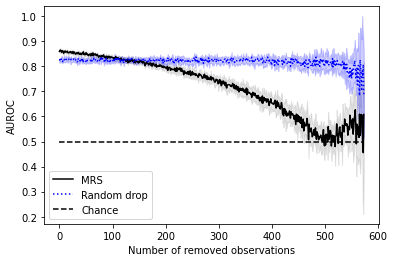

In [93]:
save = False
file_directory = os.path.join(os.getcwd(), "final_results/random/")
os.makedirs(file_directory, exist_ok=True)
save = False

experiment_label = 'Random drop'
file_name = result_dir + '/random_drop_experiment'
plot_experiment_comparison_auc(gesis_median_aucs, gesis_std_aucs,
                               median_aucs_random_drop, std_aucs_random_drop, 
                               experiment_label, drop, file_name+'aucs',  save)
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_random_drop, 
                               std_mmds_random_drop, 
                               experiment_label, drop, mmd_iteration, file_directory+'mmd',  save=save)